In [137]:
# 필수 기본 라이브러리
import numpy as np
import pandas as pd
import os
import copy

# 시각화 툴
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
from matplotlib import colormaps
import seaborn as sns

# 전처리 툴
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

# 시드 고정
np.random.seed(42)

In [138]:
# 원본 CSV 파일 로드

path = "mym470/Gas-Detection-and-Identification-Using-Multimodal/datas/gas_sensors_dataset/Gas_Sensors_Measurements.csv"

def load_data(path):
    csv_path = f"/data2/project/2025summer/{path}"
    sensor_df = pd.read_csv(csv_path)

    return sensor_df

sensor_df = load_data(path)

In [139]:
# Gas 종류 별 DataFrame 분할 (index 유지) 필요시 .reset_index(drop=True)

def split_gas(sensor_df):
    NoGas_df = sensor_df.loc[sensor_df['Gas']=='NoGas']
    Perfume_df = sensor_df.loc[sensor_df['Gas']=='Perfume']
    Smoke_df = sensor_df.loc[sensor_df['Gas']=='Smoke']
    Mixture_df = sensor_df.loc[sensor_df['Gas']=='Mixture']

    return NoGas_df, Perfume_df, Smoke_df, Mixture_df

NoGas_df, Perfume_df, Smoke_df, Mixture_df = split_gas(sensor_df)

In [140]:
gas_ranges = {
    'Smoke': [
        (0, 43), (44, 101), (102, 198), (199, 250), (251, 330), (331, 439),
        (440, 511), (512, 609), (610, 703), (704, 823), (824, 951), (952, 1017),
        (1018, 1095), (1096, 1175), (1176, 1251), (1252, 1324), (1325, 1401),
        (1402, 1459), (1460, 1534), (1535, 1599)
    ], 
    'Perfume': [
        (0, 94), (95, 161), (162, 228), (229, 311), (312, 378), (379, 431),
        (432, 486), (487, 540), (541, 589), (590, 635), (636, 689), (690, 739),
        (740, 794), (795, 843), (844, 883), (884, 922), (923, 988), (989, 1029),
        (1030, 1060), (1061, 1107), (1108, 1159), (1160, 1200), (1201, 1273),
        (1274, 1332), (1333, 1373), (1374, 1455), (1456, 1538), (1539, 1599)
    ],
    'NoGas': [
        (0, 55), (56, 78), (79, 131), (132, 184), (185, 222), (223, 274),
        (275, 340), (341, 408), (409, 472), (473, 542), (543, 617), (618, 683),
        (684, 750), (751, 816), (817, 888), (889, 967), (968, 1047), (1048, 1126),
        (1127, 1224), (1225, 1302), (1303, 1390), (1391, 1461), (1462, 1532), (1533, 1599)
    ],
    'NoGas_filtered': [
        (79, 131), (132, 184), (185, 222), (223, 274),
        (275, 340), (341, 408), (409, 472), (473, 542), (543, 617), (618, 683),
        (684, 750), (751, 816), (817, 888), (889, 967), (968, 1047), (1048, 1126),
        (1127, 1224), (1225, 1302), (1303, 1390), (1391, 1461), (1462, 1532), (1533, 1599)
    ],
    'Mixture': [
        (0, 54), (55, 123), (124, 231), (232, 343), (344, 415), (416, 460),
        (461, 553), (554, 603), (604, 660), (661, 730), (731, 777), (778, 839),
        (840, 893), (894, 1011), (1012, 1130), (1131, 1246), (1247, 1374), 
        (1375, 1556), (1557, 1600)
    ]
}


In [141]:
for i in range(2):  # range로 변경
    remove_start, remove_end = gas_ranges['NoGas'][i]
    
    NoGas_df = NoGas_df.drop(
        NoGas_df.index[(NoGas_df.index >= remove_start) & (NoGas_df.index <= remove_end)]
    )

NoGas_df_filtered = NoGas_df.reset_index(drop=True)

print(f"원래 데이터 개수: {len(NoGas_df) + (remove_end - remove_start + 1) * 2}")
print(f"제거 후 데이터 개수: {len(NoGas_df_filtered)}")
NoGas_df_filtered

원래 데이터 개수: 1567
제거 후 데이터 개수: 1521


Serial Number  MQ2  MQ3  MQ5  MQ6  MQ7  MQ8  MQ135    Gas  \
0                79  641  522  414  400  650  603    433  NoGas   
1                80  641  520  415  400  652  604    434  NoGas   
2                81  640  522  414  400  659  610    438  NoGas   
3                82  693  526  439  444  656  693    465  NoGas   
4                83  690  524  437  441  654  688    462  NoGas   
...             ...  ...  ...  ...  ...  ...  ...    ...    ...   
1516           1595  776  527  431  427  550  630    529  NoGas   
1517           1596  775  527  430  426  550  628    529  NoGas   
1518           1597  774  526  428  425  548  624    528  NoGas   
1519           1598  774  523  428  423  547  621    527  NoGas   
1520           1599  774  523  428  423  547  621    527  NoGas   

     Corresponding Image Name  
0                    79_NoGas  
1                    80_NoGas  
2                    81_NoGas  
3                    82_NoGas  
4                    83_NoGas  
...                       ...  
1516               1595_NoGas  
1517               1596_NoGas  
1518               1597_NoGas  
1519               1598_NoGas  
1520               1599_NoGas  

[1521 rows x 10 columns]

In [157]:
# 만든 df concat해서 전체 가스로 합치기

def concat_all_gas_df(all_gas_df_list=None):
    concat_df = all_gas_df_list[0]
    
    for gas_df in all_gas_df_list[1:]:
        concat_df = pd.concat([concat_df, gas_df])

    return concat_df

concat_all_gas_df([norm_nogas_filtered_df, norm_perfume_df, norm_smoke_df, norm_mixture_df]).reset_index(drop=True)

Serial Number       MQ2       MQ3       MQ5       MQ6       MQ7  \
0                79  0.018868  0.285714  0.137931  0.043478  0.405405   
1                80  0.018868  0.000000  0.172414  0.043478  0.459459   
2                81  0.000000  0.285714  0.137931  0.043478  0.648649   
3                82  1.000000  0.857143  1.000000  1.000000  0.567568   
4                83  0.943396  0.571429  0.931034  0.934783  0.513514   
...             ...       ...       ...       ...       ...       ...   
6316           1595  0.712000  0.952381  0.688889  0.732394  0.733945   
6317           1596  0.648000  0.904762  0.644444  0.690141  0.688073   
6318           1597  0.488000  0.857143  0.588889  0.633803  0.577982   
6319           1598  0.504000  0.857143  0.566667  0.605634  0.550459   
6320           1599  0.512000  0.809524  0.544444  0.563380  0.522936   

           MQ8     MQ135      Gas Corresponding Image Name  
0     0.162162  0.027027    NoGas                 79_NoGas  
1     0.171171  0.054054    NoGas                 80_NoGas  
2     0.225225  0.162162    NoGas                 81_NoGas  
3     0.972973  0.891892    NoGas                 82_NoGas  
4     0.927928  0.810811    NoGas                 83_NoGas  
...        ...       ...      ...                      ...  
6316  0.692308  0.725490  Mixture             1595_Mixture  
6317  0.641026  0.627451  Mixture             1596_Mixture  
6318  0.576923  0.588235  Mixture             1597_Mixture  
6319  0.538462  0.607843  Mixture             1598_Mixture  
6320  0.500000  0.686275  Mixture             1599_Mixture  

[6321 rows x 10 columns]

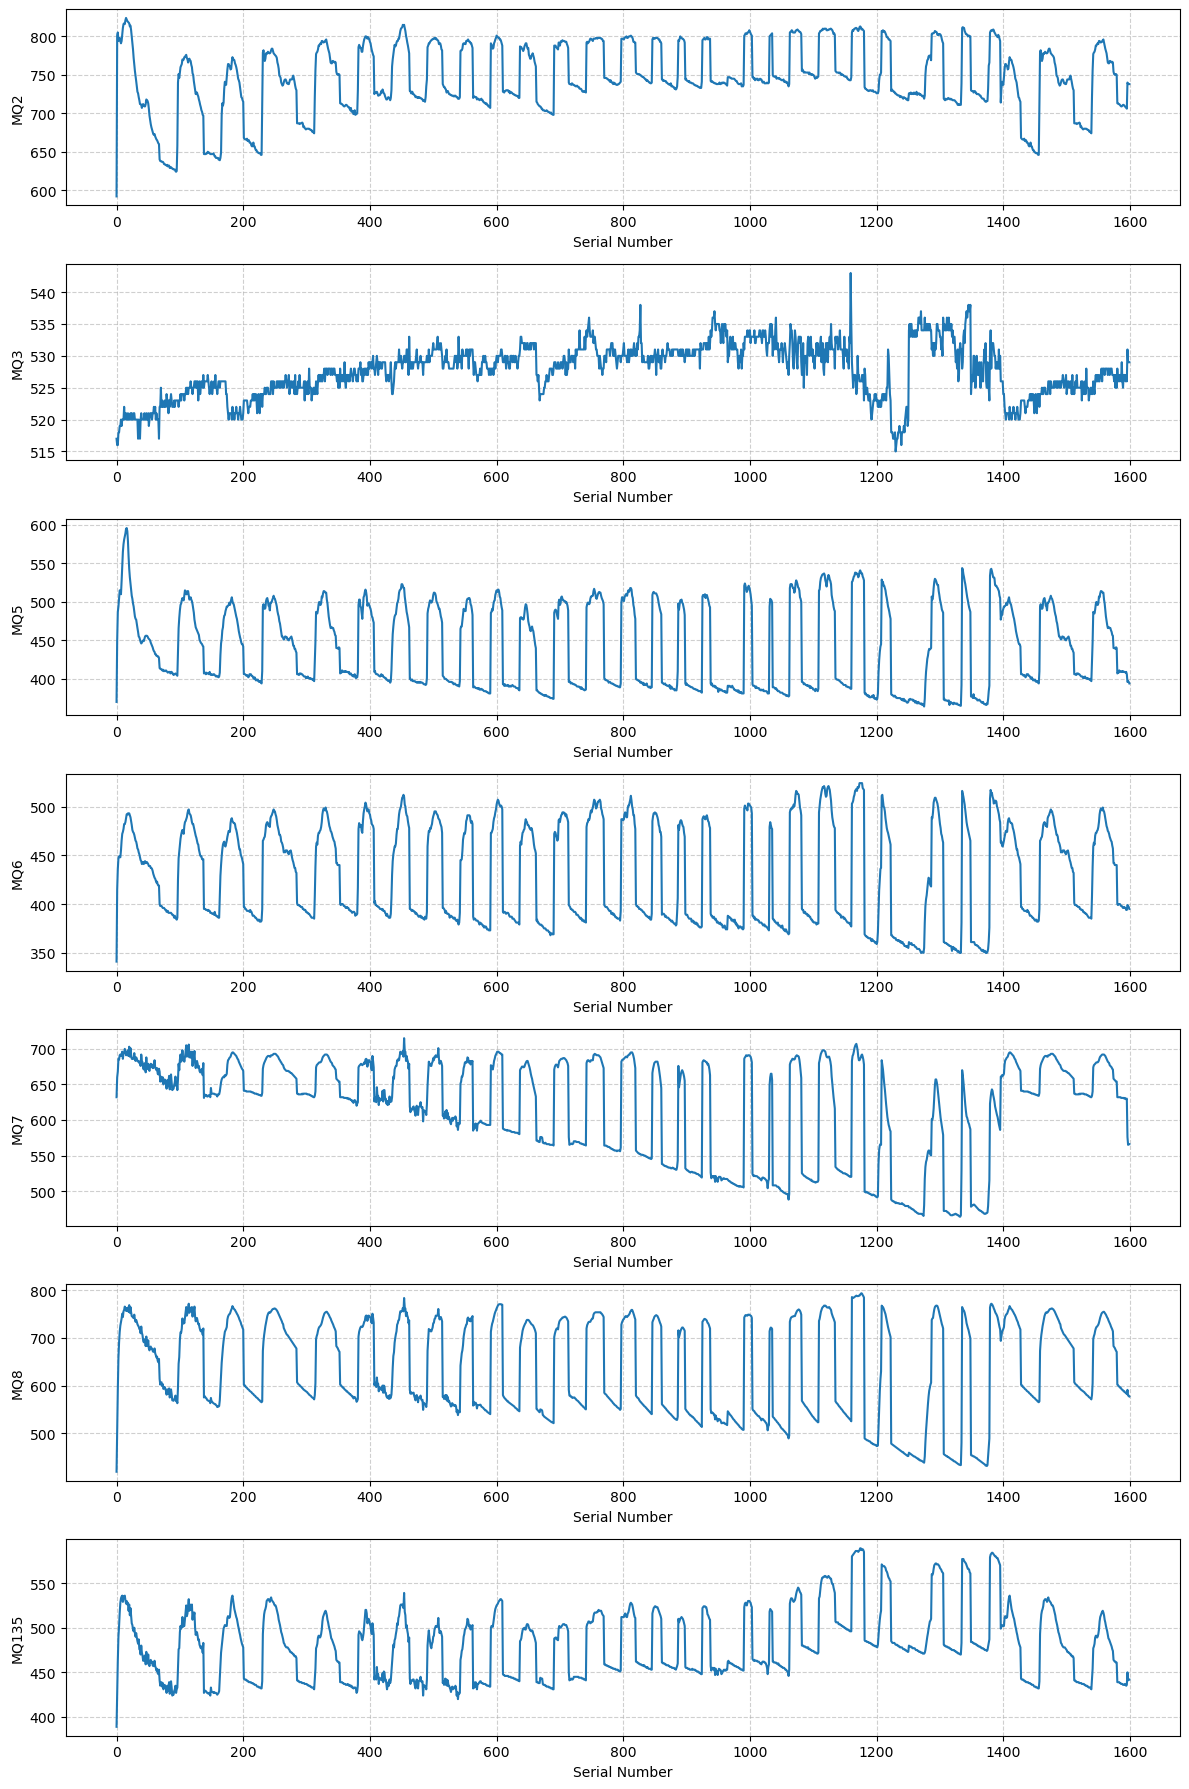

In [143]:
# Gas 종류 별 시각화

gas_type_df = Perfume_df

def plot_sensor_data(gas_type_df):
    sensor_cols = ['MQ2', 'MQ3', 'MQ5', 'MQ6', 'MQ7', 'MQ8', 'MQ135']

    # subplot 생성
    fig, axes = plt.subplots(nrows=len(sensor_cols), ncols=1, figsize=(12, 18), sharex=True)
    
    for i, sensor in enumerate(sensor_cols):
        axes[i].plot(gas_type_df['Serial Number'], gas_type_df[sensor])
        axes[i].set_ylabel(sensor)
        axes[i].set_xlabel('Serial Number')
        axes[i].tick_params(labelbottom=True)
        axes[i].grid(True, linestyle='--', alpha=0.6)

    # 레이아웃 먼저 조정
    plt.tight_layout()
    plt.show()

plot_sensor_data(gas_type_df)

In [144]:
ranges = gas_ranges['NoGas_filtered']
ranges

[(79, 131),
 (132, 184),
 (185, 222),
 (223, 274),
 (275, 340),
 (341, 408),
 (409, 472),
 (473, 542),
 (543, 617),
 (618, 683),
 (684, 750),
 (751, 816),
 (817, 888),
 (889, 967),
 (968, 1047),
 (1048, 1126),
 (1127, 1224),
 (1225, 1302),
 (1303, 1390),
 (1391, 1461),
 (1462, 1532),
 (1533, 1599)]

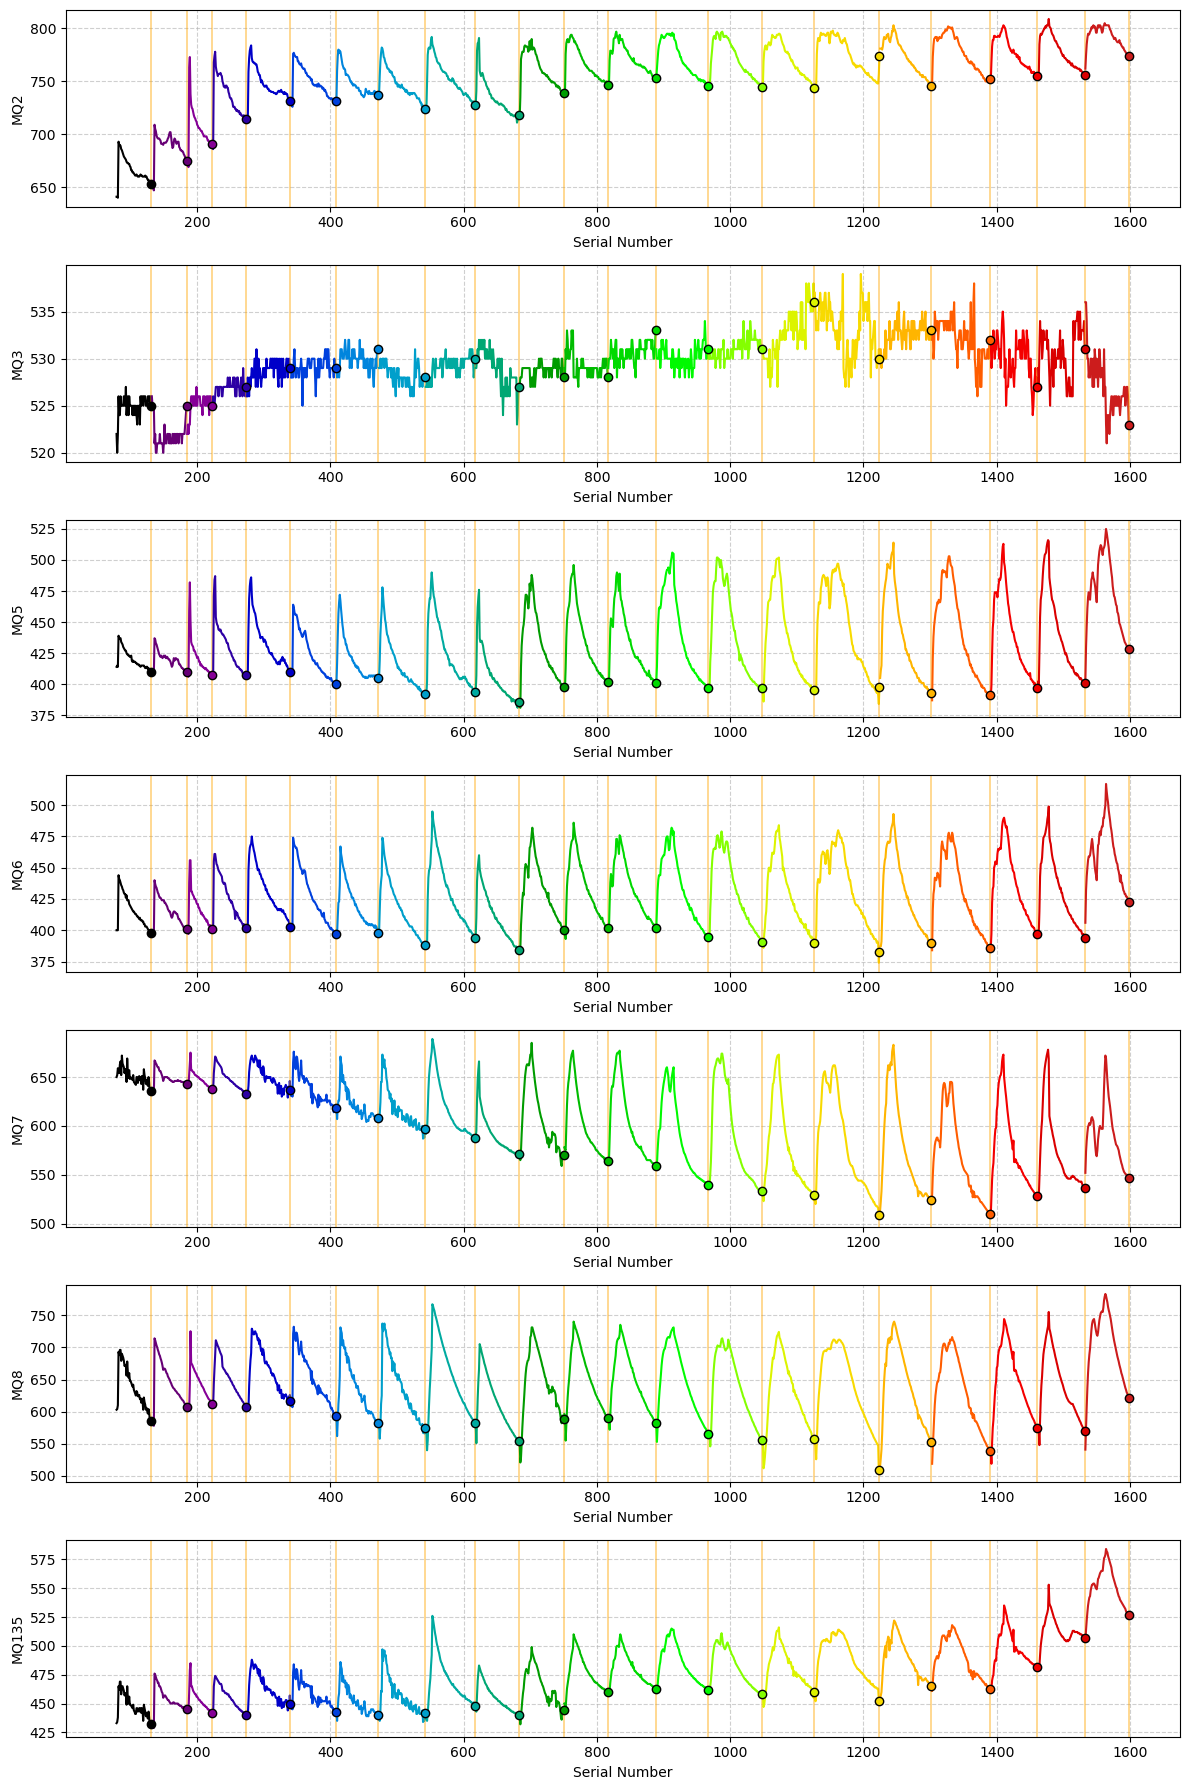

In [145]:
# 구간 자르고 구간 별 선 긋고 시각화

gas_type_df = NoGas_df_filtered
ranges = gas_ranges['NoGas_filtered']

def plot_sensor_with_segment(gas_type_df, ranges):
    sensor_cols = ['MQ2', 'MQ3', 'MQ5', 'MQ6', 'MQ7', 'MQ8', 'MQ135']

    # 색상 리스트 생성
    base_cmap = colormaps.get_cmap('nipy_spectral')  # 컬러맵 객체 생성
    cmap = lambda i: base_cmap(i / len(ranges))  # 인덱스 범위 변환
    
    # subplot 생성
    fig, axes = plt.subplots(nrows=len(sensor_cols), ncols=1, figsize=(12, 18), sharex=True)
    
    for i, sensor in enumerate(sensor_cols):
        for segment_id, (start, end) in enumerate(ranges): # 구간 별 ID 설정, 시작 끝점 설정
            segment = gas_type_df.loc[(gas_type_df['Serial Number']>=start) & (gas_type_df['Serial Number']<=end)] # 구간 설정
            axes[i].plot(segment['Serial Number'], segment[sensor], color=cmap(segment_id))

            end_value = segment.loc[segment['Serial Number']==end, sensor].values[0] # 종료지점 y축값
            axes[i].scatter(end, end_value, color=cmap(segment_id), edgecolor='black', zorder=5)

            axes[i].axvline(x=end, color='orange', linestyle='-', linewidth=1.2, alpha=0.5)
            
        axes[i].set_ylabel(sensor)
        axes[i].set_xlabel('Serial Number')
        axes[i].tick_params(labelbottom=True)
        axes[i].grid(True, linestyle='--', alpha=0.6)

    # 레이아웃 조정
    plt.tight_layout()
    plt.show()

    # 이미지 저장
    # plt.savefig('smoke_sensor_plot.png')
    
plot_sensor_with_segment(gas_type_df, ranges)

In [146]:
# 메타 데이터셋 생성

gas_type_df = NoGas_df_filtered
ranges = gas_ranges['NoGas_filtered']

def create_metadata_df(gas_type_df, ranges):
    results = []

    sensor_cols = ['MQ2', 'MQ3', 'MQ5', 'MQ6', 'MQ7', 'MQ8', 'MQ135']
    
    for i, sensor in enumerate(sensor_cols):
        for segment_id, (start, end) in enumerate(ranges): # 구간 별 ID 설정, 시작 끝점 설정
            segment = gas_type_df.loc[(gas_type_df['Serial Number']>=start) & (gas_type_df['Serial Number']<=end)] # 구간 설정
    
            # 통계값 계산
            min_val = segment[sensor].min()
            max_val = segment[sensor].max()
            mean_val = segment[sensor].mean()

            min_point = segment.loc[segment[sensor] == min_val, 'Serial Number'].values[0]
            max_point = segment.loc[segment[sensor] == max_val, 'Serial Number'].values[0]

            start_val = gas_type_df.loc[gas_type_df['Serial Number'] == start, sensor].values[0]
            end_val = gas_type_df.loc[gas_type_df['Serial Number'] == end, sensor].values[0]
    
            results.append({
                'Gas_Type': segment['Gas'].iloc[0],
                'Sensor': sensor,
                'Interval_Num': segment_id,
                'Start_Point': start,
                'End_Point': end,
                'Min_Point': min_point,
                'Max_Point': max_point,
                'Start_Value': start_val,
                'End_Value': end_val,
                'Min_Value': min_val,
                'Max_Value': max_val,
                'Mean_Value': mean_val,
            })
    
    # DataFrame으로 변환
    meta_df = pd.DataFrame(results)

    return meta_df

create_metadata_df(gas_type_df, ranges)

Gas_Type Sensor  Interval_Num  Start_Point  End_Point  Min_Point  \
0      NoGas    MQ2             0           79        131         81   
1      NoGas    MQ2             1          132        184        135   
2      NoGas    MQ2             2          185        222        187   
3      NoGas    MQ2             3          223        274        224   
4      NoGas    MQ2             4          275        340        276   
..       ...    ...           ...          ...        ...        ...   
149    NoGas  MQ135            17         1225       1302       1225   
150    NoGas  MQ135            18         1303       1390       1303   
151    NoGas  MQ135            19         1391       1461       1391   
152    NoGas  MQ135            20         1462       1532       1462   
153    NoGas  MQ135            21         1533       1599       1533   

     Max_Point  Start_Value  End_Value  Min_Value  Max_Value  Mean_Value  
0           82          641        653        640        693  665.924528  
1          136          651        675        647        709  688.698113  
2          189          673        691        669        773  706.210526  
3          227          688        714        686        778  735.596154  
4          281          715        731        714        784  747.318182  
..         ...          ...        ...        ...        ...         ...  
149       1246          454        465        454        522  488.974359  
150       1333          461        463        461        518  489.477273  
151       1411          462        482        462        535  497.394366  
152       1478          481        507        481        553  513.000000  
153       1564          504        527        504        584  550.835821  

[154 rows x 12 columns]

In [158]:
# 각 구간마다 정규화 (min max 정규화임)

gas_type_df = NoGas_df_filtered

ranges = gas_ranges['NoGas_filtered']

def normalize_sensors_with_minmax(gas_type_df, ranges):
    sensor_cols = ['MQ2', 'MQ3', 'MQ5', 'MQ6', 'MQ7', 'MQ8', 'MQ135']

    conc_df = []
    
    for segment_id, (start, end) in enumerate(ranges): # 구간 별 ID 설정, 시작 끝점 설정
        segment = gas_type_df.loc[(gas_type_df['Serial Number']>=start) & (gas_type_df['Serial Number']<=end)].copy()
            
        scaled = segment.copy()
        scaler = MinMaxScaler(feature_range=(0,1))
        scaled[sensor_cols] = scaler.fit_transform(segment[sensor_cols])
        
        conc_df.append(scaled)

    return pd.concat(conc_df)

norm_nogas_filtered_df = normalize_sensors_with_minmax(gas_type_df, ranges)
norm_nogas_filtered_df

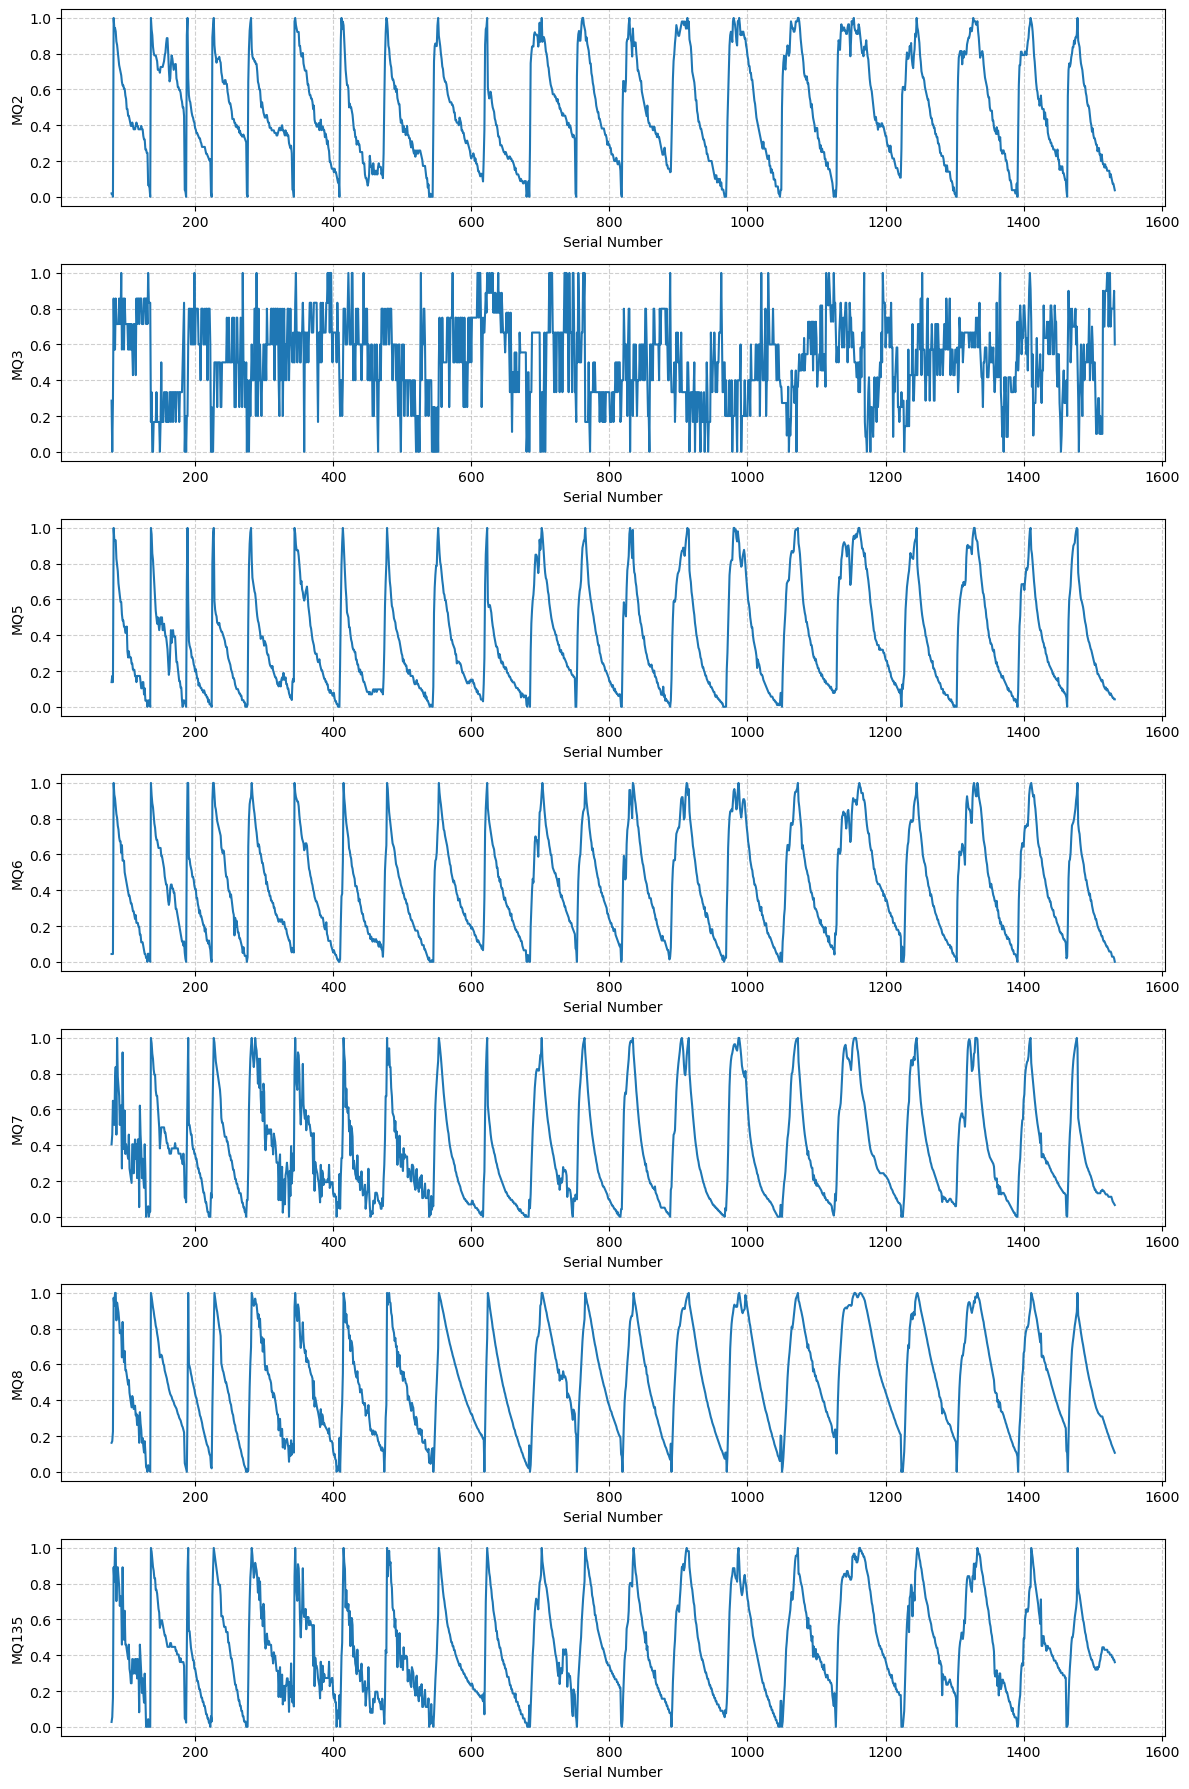

In [124]:
def plot_sensor_data(gas_type_df):
    sensor_cols = ['MQ2', 'MQ3', 'MQ5', 'MQ6', 'MQ7', 'MQ8', 'MQ135']

    # subplot 생성
    fig, axes = plt.subplots(nrows=len(sensor_cols), ncols=1, figsize=(12, 18), sharex=True)
    
    for i, sensor in enumerate(sensor_cols):
        axes[i].plot(gas_type_df['Serial Number'], gas_type_df[sensor])
        axes[i].set_ylabel(sensor)
        axes[i].set_xlabel('Serial Number')
        axes[i].tick_params(labelbottom=True)
        axes[i].grid(True, linestyle='--', alpha=0.6)

    # 레이아웃 먼저 조정
    plt.tight_layout()
    plt.show()

plot_sensor_data(norm_nogas_filtered_df)

In [148]:
# 기존 데이터셋 정규화 후 구간 정보 추가

gas_type_df = Perfume_df
ranges = gas_ranges['Perfume']

def add_segment_info(gas_type_df, ranges):
    # 기존 정규화 함수 사용
    normalized_df = normalize_sensors_with_minmax(gas_type_df, ranges)
    
    # Interval 컬럼 추가
    normalized_df['Interval'] = ''
    
    for segment_id, (start, end) in enumerate(ranges):
        # 해당 구간의 데이터에 Interval 정보 추가
        mask = (normalized_df['Serial Number'] >= start) & (normalized_df['Serial Number'] <= end)
        normalized_df.loc[mask, 'Interval'] = f"{start}-{end}"
    
    # 컬럼 순서 정리
    column_order = ['Serial Number', 'MQ2', 'MQ3', 'MQ5', 'MQ6', 'MQ7', 'MQ8', 'MQ135', 'Gas', 'Interval', 'Corresponding Image Name']
    result = normalized_df[column_order]
    
    return result

processed_perfume_df = add_segment_info(gas_type_df, ranges)
processed_perfume_df

Serial Number       MQ2       MQ3       MQ5       MQ6       MQ7  \
1600              0  0.000000  0.111111  0.000000  0.000000  0.000000   
1601              1  0.900862  0.000000  0.353982  0.486842  0.394366   
1602              2  0.918103  0.000000  0.517699  0.625000  0.507042   
1603              3  0.870690  0.222222  0.548673  0.697368  0.760563   
1604              4  0.879310  0.222222  0.592920  0.710526  0.746479   
...             ...       ...       ...       ...       ...       ...   
3195           1595  0.262295  0.285714  0.100000  0.078947  0.511811   
3196           1596  0.540984  1.000000  0.016667  0.122807  0.086614   
3197           1597  0.524590  0.714286  0.025000  0.114035  0.000000   
3198           1598  0.524590  0.714286  0.016667  0.105263  0.007874   
3199           1599  0.524590  0.714286  0.000000  0.087719  0.007874   

           MQ8     MQ135      Gas   Interval Corresponding Image Name  
1600  0.000000  0.000000  Perfume       0-94                0_Perfume  
1601  0.251429  0.265306  Perfume       0-94                1_Perfume  
1602  0.491429  0.503401  Perfume       0-94                2_Perfume  
1603  0.682857  0.687075  Perfume       0-94                3_Perfume  
1604  0.777143  0.768707  Perfume       0-94                4_Perfume  
...        ...       ...      ...        ...                      ...  
3195  0.059783  0.056818  Perfume  1539-1599             1595_Perfume  
3196  0.108696  0.215909  Perfume  1539-1599             1596_Perfume  
3197  0.043478  0.113636  Perfume  1539-1599             1597_Perfume  
3198  0.043478  0.125000  Perfume  1539-1599             1598_Perfume  
3199  0.032609  0.125000  Perfume  1539-1599             1599_Perfume  

[1600 rows x 11 columns]

In [15]:
# 디버깅 코드 (Claude 사용)

gas_type_df = Perfume_df
ranges = gas_ranges['Perfume']

def debug_normalize_sensors_with_minmax(gas_type_df, ranges):
    sensor_cols = ['MQ2', 'MQ3', 'MQ5', 'MQ6', 'MQ7', 'MQ8', 'MQ135']
    conc_df = []
    total_processed = 0
    
    for segment_id, (start, end) in enumerate(ranges):
        segment = gas_type_df.loc[(gas_type_df['Serial Number']>=start) & (gas_type_df['Serial Number']<=end)].copy()
        
        print(f"구간 {segment_id}: Serial Number {start}~{end}, 데이터 개수: {len(segment)}")
        total_processed += len(segment)
        
        if segment.empty:
            continue
            
        scaled = segment.copy()
        scaler = MinMaxScaler(feature_range=(0,1))
        scaled[sensor_cols] = scaler.fit_transform(segment[sensor_cols])
        
        conc_df.append(scaled)
    
    print(f"총 처리된 데이터 개수: {total_processed}")
    print(f"원본 데이터 개수: {len(gas_type_df)}")
    
    return pd.concat(conc_df, ignore_index=True) if conc_df else pd.DataFrame()

# 디버깅 실행
print(f"{gas_type_df['Gas'].unique()[0]}:", ranges)
debug_result = debug_normalize_sensors_with_minmax(gas_type_df, ranges)
print(f"결과 데이터 개수: {len(debug_result)}")

Perfume: [(0, 94), (95, 161), (162, 228), (229, 311), (312, 378), (379, 431), (432, 486), (487, 540), (541, 589), (590, 635), (636, 689), (690, 739), (740, 794), (795, 843), (844, 883), (884, 922), (923, 988), (989, 1029), (1030, 1060), (1061, 1107), (1108, 1159), (1160, 1200), (1201, 1273), (1274, 1332), (1333, 1373), (1374, 1455), (1456, 1538), (1539, 1599)]
구간 0: Serial Number 0~94, 데이터 개수: 95
구간 1: Serial Number 95~161, 데이터 개수: 67
구간 2: Serial Number 162~228, 데이터 개수: 67
구간 3: Serial Number 229~311, 데이터 개수: 83
구간 4: Serial Number 312~378, 데이터 개수: 67
구간 5: Serial Number 379~431, 데이터 개수: 53
구간 6: Serial Number 432~486, 데이터 개수: 55
구간 7: Serial Number 487~540, 데이터 개수: 54
구간 8: Serial Number 541~589, 데이터 개수: 49
구간 9: Serial Number 590~635, 데이터 개수: 46
구간 10: Serial Number 636~689, 데이터 개수: 54
구간 11: Serial Number 690~739, 데이터 개수: 50
구간 12: Serial Number 740~794, 데이터 개수: 55
구간 13: Serial Number 795~843, 데이터 개수: 49
구간 14: Serial Number 844~883, 데이터 개수: 40
구간 15: Serial Number 884~922, 데이터 개수

In [16]:
# df를 csv로 저장하는 함수

def df_to_csv(df, file_path, index=False, encoding='utf-8-sig'):
    df.to_csv(file_path, index=index, encoding=encoding)

In [17]:
# 구간별 이동평균

gas_type_df = Perfume_df
ranges = gas_ranges['Perfume']

def segment_moving_average(gas_type_df, ranges, window=7):
    segments_df = []

    sensor_cols = ['MQ2', 'MQ3', 'MQ5', 'MQ6', 'MQ7', 'MQ8', 'MQ135']
    
    for start, end in ranges:
        segment = gas_type_df.loc[(gas_type_df['Serial Number']>=start) & (gas_type_df['Serial Number']<=end)].copy()

        if len(segment) > window:
            for col in sensor_cols:
                segment[f'{col}_MA{window}'] = segment[col].rolling(window=window).mean()

        segments_df.append(segment)
        
    return pd.concat(segments_df)
    
segment_ma_perfume_df = segment_moving_average(norm_perfume_df, ranges, 7)

segment_ma_perfume_df

Serial Number       MQ2       MQ3       MQ5       MQ6       MQ7  \
1600              0  0.000000  0.111111  0.000000  0.000000  0.000000   
1601              1  0.900862  0.000000  0.353982  0.486842  0.394366   
1602              2  0.918103  0.000000  0.517699  0.625000  0.507042   
1603              3  0.870690  0.222222  0.548673  0.697368  0.760563   
1604              4  0.879310  0.222222  0.592920  0.710526  0.746479   
...             ...       ...       ...       ...       ...       ...   
3195           1595  0.262295  0.285714  0.100000  0.078947  0.511811   
3196           1596  0.540984  1.000000  0.016667  0.122807  0.086614   
3197           1597  0.524590  0.714286  0.025000  0.114035  0.000000   
3198           1598  0.524590  0.714286  0.016667  0.105263  0.007874   
3199           1599  0.524590  0.714286  0.000000  0.087719  0.007874   

           MQ8     MQ135      Gas Corresponding Image Name   MQ2_MA7  \
1600  0.000000  0.000000  Perfume                0_Perfume       NaN   
1601  0.251429  0.265306  Perfume                1_Perfume       NaN   
1602  0.491429  0.503401  Perfume                2_Perfume       NaN   
1603  0.682857  0.687075  Perfume                3_Perfume       NaN   
1604  0.777143  0.768707  Perfume                4_Perfume       NaN   
...        ...       ...      ...                      ...       ...   
3195  0.059783  0.056818  Perfume             1595_Perfume  0.286885   
3196  0.108696  0.215909  Perfume             1596_Perfume  0.320843   
3197  0.043478  0.113636  Perfume             1597_Perfume  0.352459   
3198  0.043478  0.125000  Perfume             1598_Perfume  0.385246   
3199  0.032609  0.125000  Perfume             1599_Perfume  0.419204   

       MQ3_MA7   MQ5_MA7   MQ6_MA7   MQ7_MA7   MQ8_MA7  MQ135_MA7  
1600       NaN       NaN       NaN       NaN       NaN        NaN  
1601       NaN       NaN       NaN       NaN       NaN        NaN  
1602       NaN       NaN       NaN       NaN       NaN        NaN  
1603       NaN       NaN       NaN       NaN       NaN        NaN  
1604       NaN       NaN       NaN       NaN       NaN        NaN  
...        ...       ...       ...       ...       ...        ...  
3195  0.346939  0.121429  0.092732  0.514061  0.082298   0.056818  
3196  0.469388  0.104762  0.096491  0.452193  0.083075   0.079545  
3197  0.510204  0.090476  0.098997  0.377953  0.076087   0.087662  
3198  0.551020  0.075000  0.098997  0.305962  0.069099   0.097403  
3199  0.591837  0.057143  0.097744  0.232846  0.062112   0.105519  

[1600 rows x 17 columns]

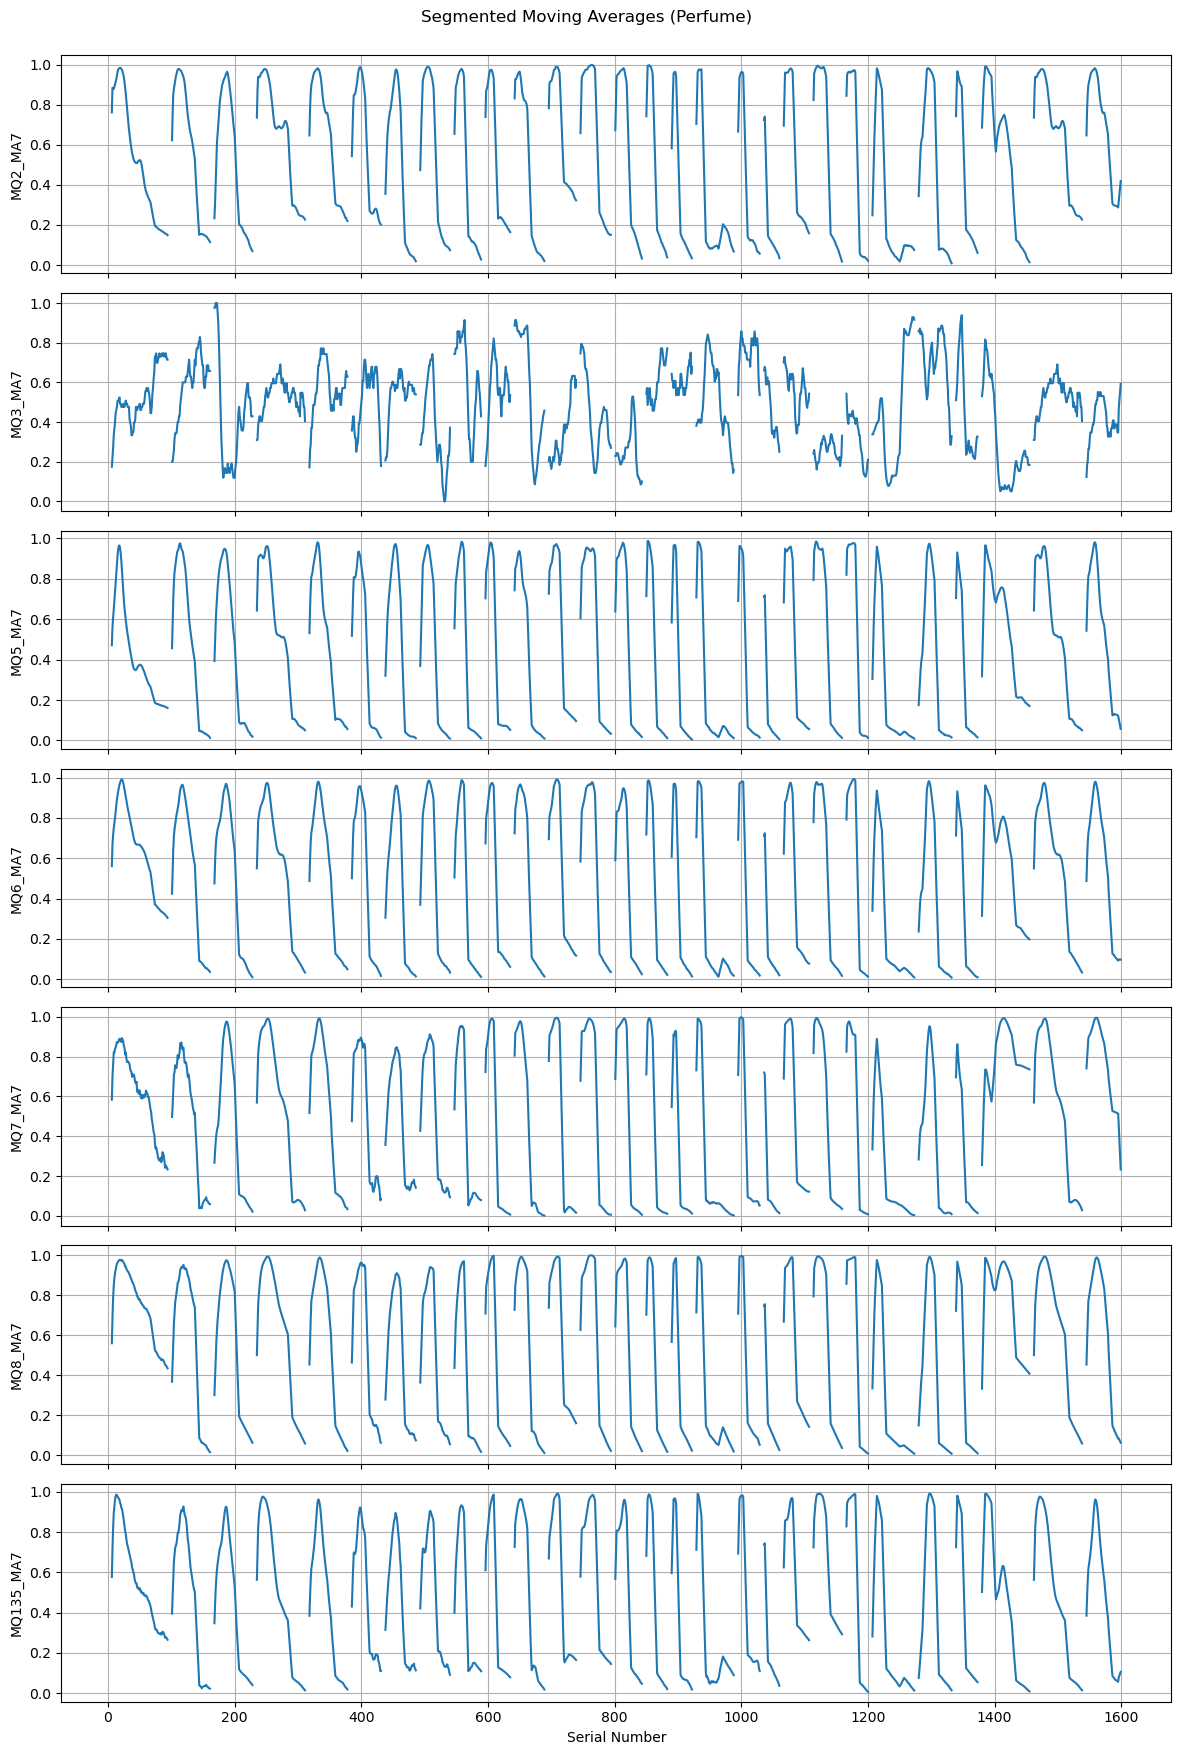

In [28]:
# 이동평균선 시각화

def plot_moving_average_7(df):
    sensor_ma_cols = [col for col in df.columns if col.endswith('_MA7')]
    
    fig, axes = plt.subplots(len(sensor_ma_cols), 1, figsize=(12, 2.5*len(sensor_ma_cols)), sharex=True)

    for ax, col in zip(axes, sensor_ma_cols):
        ax.plot(df['Serial Number'], df[col])
        ax.set_ylabel(col)
        ax.grid(True)

    axes[-1].set_xlabel('Serial Number')
    fig.suptitle(f"Segmented Moving Averages ({df['Gas'].unique()[0]})", y=1)
    plt.tight_layout()
    plt.show()

plot_moving_average_7(segment_ma_perfume_df)

In [19]:
segment_ma_meta_df = create_metadata_df(segment_ma_perfume_df, gas_ranges[segment_ma_perfume_df['Gas'].unique()[0]])
segment_ma_meta_df

Gas_Type Sensor  Interval_Num  Start_Point  End_Point  Start_Value  \
0    Perfume    MQ2             0            0         94     0.000000   
1    Perfume    MQ2             1           95        161     0.000000   
2    Perfume    MQ2             2          162        228     0.014925   
3    Perfume    MQ2             3          229        311     0.000000   
4    Perfume    MQ2             4          312        378     0.000000   
..       ...    ...           ...          ...        ...          ...   
191  Perfume  MQ135            23         1274       1332     0.009804   
192  Perfume  MQ135            24         1333       1373     0.000000   
193  Perfume  MQ135            25         1374       1455     0.276316   
194  Perfume  MQ135            26         1456       1538     0.000000   
195  Perfume  MQ135            27         1539       1599     0.000000   

     End_Value  Min_Point  Max_Point  Min_Value  Max_Value  Mean_Value  
0     0.137931          0         15        0.0        1.0    0.511071  
1     0.099338         95        110        0.0        1.0    0.542750  
2     0.052239        163        183        0.0        1.0    0.472377  
3     0.210145        229        245        0.0        1.0    0.618561  
4     0.204918        312        331        0.0        1.0    0.598238  
..         ...        ...        ...        ...        ...         ...  
191   0.000000       1332       1293        0.0        1.0    0.372383  
192   0.046729       1333       1335        0.0        1.0    0.376795  
193   0.000000       1455       1382        0.0        1.0    0.424984  
194   0.000000       1456       1471        0.0        1.0    0.454288  
195   0.125000       1539       1557        0.0        1.0    0.453055  

[196 rows x 12 columns]

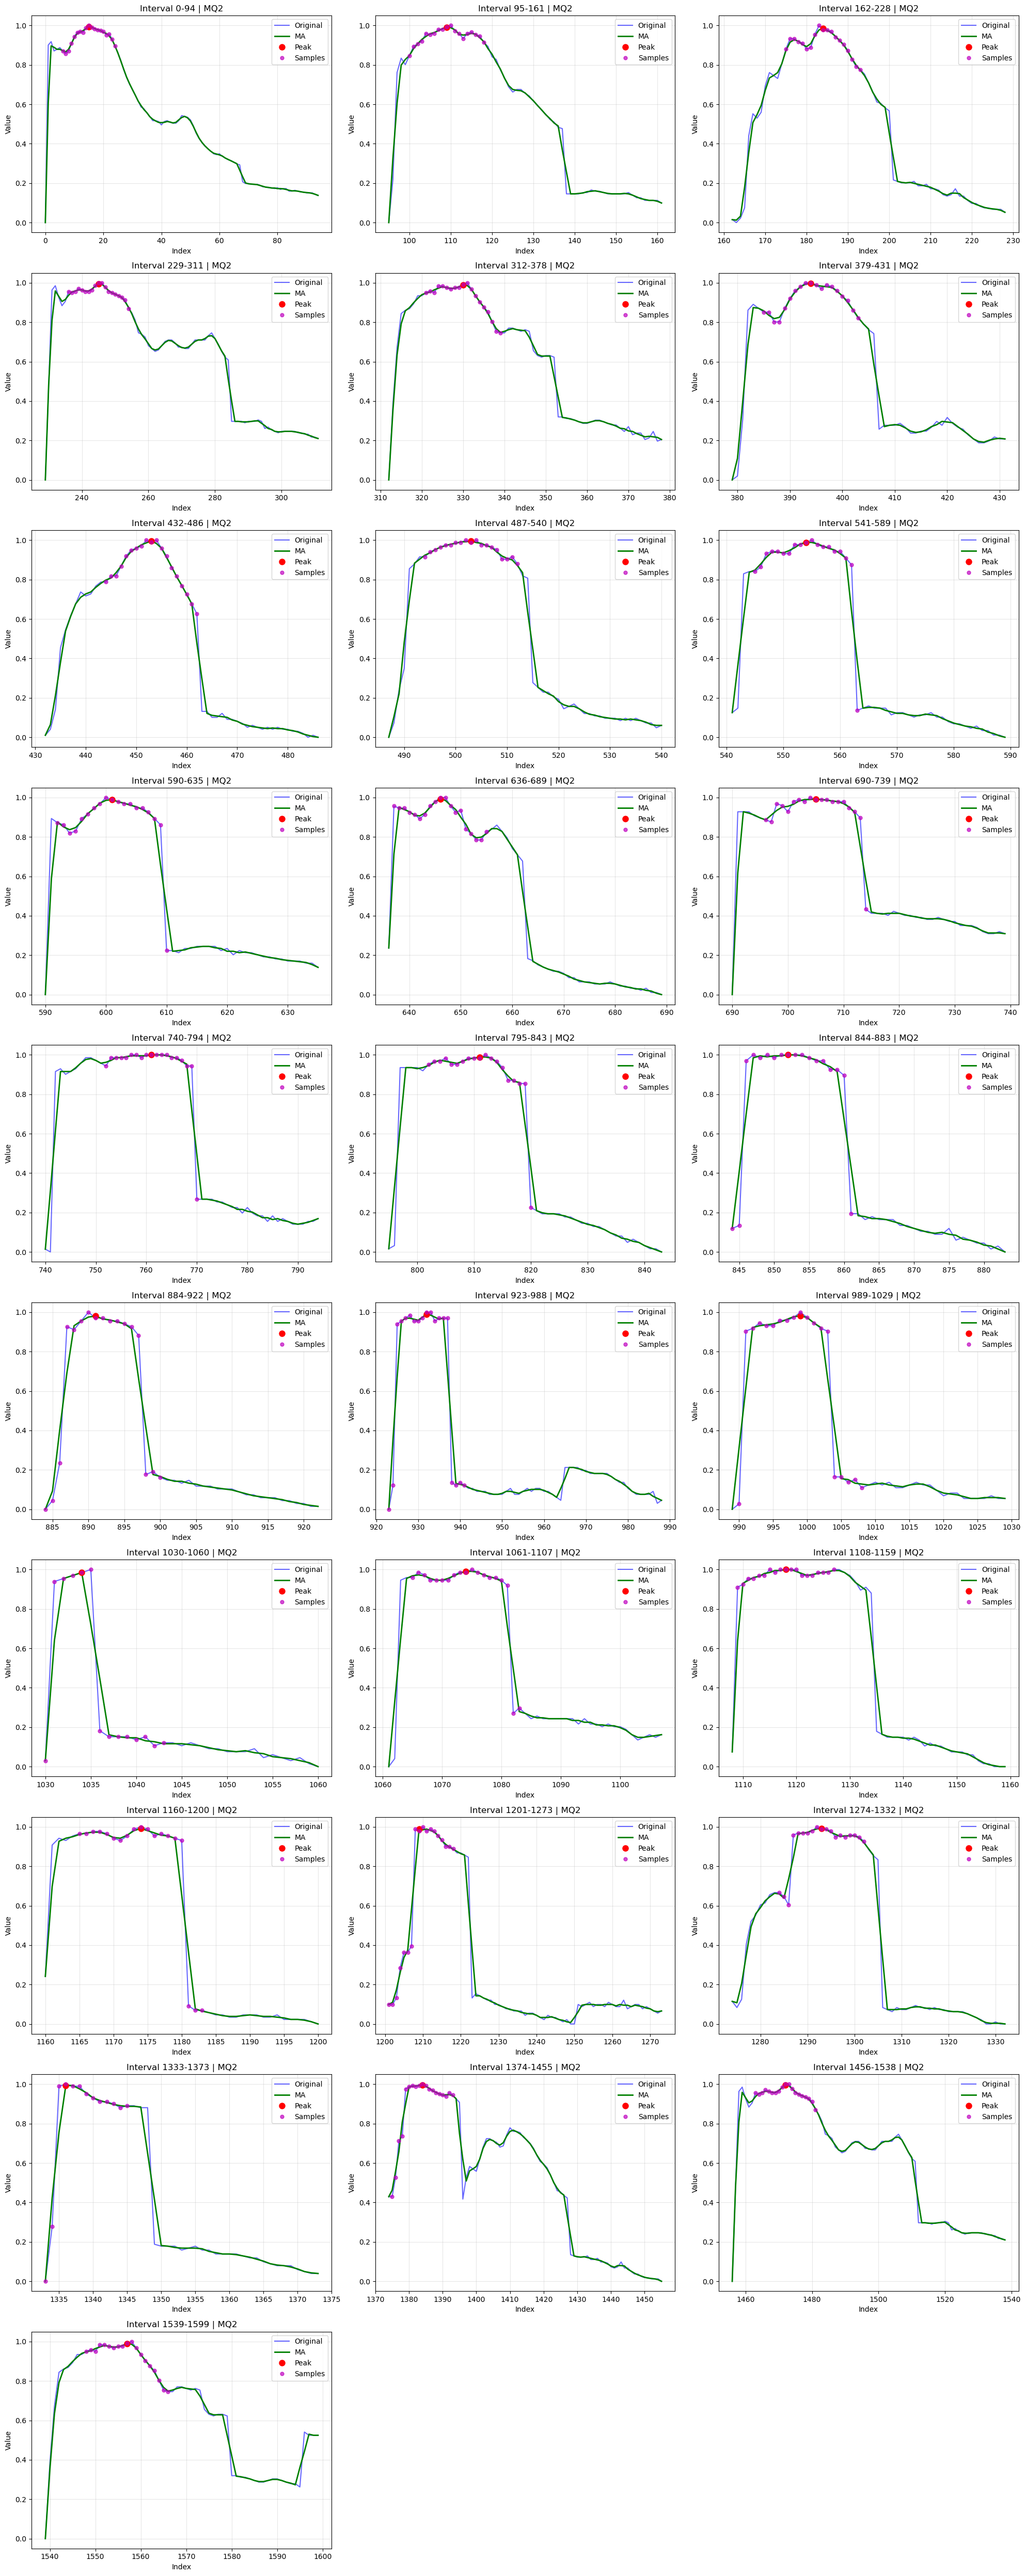

                Id  dataset      gas      interval  serial train_test
0    Perfume_4_325        4  Perfume    (312, 378)     325      train
1  Perfume_20_1112       20  Perfume  (1108, 1159)    1112      train
2   Perfume_10_652       10  Perfume    (636, 689)     652      train
3  Perfume_27_1562       27  Perfume  (1539, 1599)    1562      train
4  Perfume_27_1551       27  Perfume  (1539, 1599)    1551      train


In [162]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# 1) Perfume 구간(튜플)과 데이터 지정
intervals_perfume = [
    (0, 94), (95, 161), (162, 228), (229, 311), (312, 378), (379, 431),
    (432, 486), (487, 540), (541, 589), (590, 635), (636, 689), (690, 739),
    (740, 794), (795, 843), (844, 883), (884, 922), (923, 988), (989, 1029),
    (1030, 1060), (1061, 1107), (1108, 1159), (1160, 1200), (1201, 1273),
    (1274, 1332), (1333, 1373), (1374, 1455), (1456, 1538), (1539, 1599)
]

sensor_columns = ['MQ2','MQ3','MQ5','MQ6','MQ7','MQ8','MQ135']

# 인덱스 안전 확보
norm_perfume_df = norm_perfume_df.reset_index(drop=True).copy()
# (필요시) Gas 라벨 보강
if 'Gas' not in norm_perfume_df.columns:
    norm_perfume_df['Gas'] = 'Perfume'

def calculate_moving_average(s, window_size=3):
    return s.rolling(window=window_size, center=True).mean().fillna(s)

def find_peak_in_interval(df, start_idx, end_idx, sensor_col='MQ2'):
    interval_df = df.iloc[start_idx:end_idx+1]
    if len(interval_df) < 5:
        return None, None, None
    ma = calculate_moving_average(interval_df[sensor_col])
    peak_abs_idx = ma.idxmax()           # 원본 인덱스
    peak_val = ma.loc[peak_abs_idx]
    return peak_abs_idx, peak_val, ma

def extract_samples_around_peak(df, peak_idx, before=9, after=9, interval_start=None, interval_end=None):
    s = max(0, peak_idx - before)
    e = min(len(df)-1, peak_idx + after)
    if interval_start is not None: s = max(s, interval_start)
    if interval_end   is not None: e = min(e, interval_end)
    samp = df.iloc[s:e+1].copy()
    samp['relative_position'] = range(s - peak_idx, e - peak_idx + 1)
    samp['is_peak'] = samp.index == peak_idx
    return samp, s, e

def process_all_intervals(df, intervals, main_sensor='MQ2'):
    all_samples, peak_info = [], []
    n = len(intervals)
    n_cols = 3
    n_rows = (n + n_cols - 1) // n_cols
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 5*n_rows))
    axes = axes.flatten() if n > 1 else [axes]

    for i, (start_idx, end_idx) in enumerate(intervals):
        interval_df = df.iloc[start_idx:end_idx+1]
        if interval_df.empty:
            continue

        peak_idx, peak_val, ma = find_peak_in_interval(df, start_idx, end_idx, main_sensor)
        if peak_idx is None:
            continue

        samples, s_idx, e_idx = extract_samples_around_peak(
            df, peak_idx, before=9, after=9, interval_start=start_idx, interval_end=end_idx
        )
        # 라벨링
        samples['interval'] = [(start_idx, end_idx)] * len(samples)   # 튜플로 저장
        samples['Gas'] = 'Perfume'
        samples['peak_idx'] = peak_idx
        all_samples.append(samples)

        peak_info.append({
            'interval': f'{start_idx}-{end_idx}',
            'peak_idx': peak_idx,
            'peak_value': float(peak_val),
            'interval_start': start_idx,
            'interval_end': end_idx,
            'sample_start': s_idx,
            'sample_end': e_idx
        })

        # 플롯
        ax = axes[i]
        ax.plot(interval_df.index, interval_df[main_sensor], 'b-', alpha=0.6, label='Original')
        ax.plot(ma.index, ma.values, 'g-', lw=2, label='MA')
        ax.plot(peak_idx, peak_val, 'ro', ms=8, label='Peak')
        valid_idx = [idx for idx in samples.index if idx in interval_df.index]
        if valid_idx:
            ax.plot(valid_idx, interval_df.loc[valid_idx, main_sensor], 'mo', ms=5, alpha=0.7, label='Samples')
        ax.set_title(f'Interval {start_idx}-{end_idx} | {main_sensor}')
        ax.set_xlabel('Index'); ax.set_ylabel('Value'); ax.grid(True, alpha=0.3); ax.legend()

    # 남는 축 제거
    for j in range(i+1, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout(); plt.show()
    return all_samples, peak_info

# 2) Perfume 처리 실행
sampled_list, peak_info = process_all_intervals(norm_perfume_df, intervals_perfume, main_sensor='MQ2')

if sampled_list:
    final_sampled_data = pd.concat(sampled_list, ignore_index=True)

    # interval_num = intervals_perfume의 인덱스
    final_sampled_data['interval_num'] = final_sampled_data['interval'].apply(
        lambda t: intervals_perfume.index(t) if t in intervals_perfume else -1
    )

    # stratify label 생성 후 split
    final_sampled_data = final_sampled_data[final_sampled_data['interval_num'] >= 0].copy()
    final_sampled_data['stratify_label'] = (
        final_sampled_data['Gas'] + '_' + final_sampled_data['interval_num'].astype(str)
    )

    # (필요 시) 클래스 최소 샘플 확인 후 stratify 적용
    vc = final_sampled_data['stratify_label'].value_counts()
    stratify_col = final_sampled_data['stratify_label'] if (len(vc) > 1 and vc.min() >= 2) else None

    train_df, test_df = train_test_split(
        final_sampled_data,
        test_size=0.2,
        random_state=42,
        stratify=stratify_col
    )

    # 메타데이터
    def create_metadata(df, set_type):
        d = df.copy()
        d['Id'] = d.apply(lambda r: f"{r['Gas']}_{r['interval_num']}_{r['Serial Number']}", axis=1)
        d['dataset'] = d['interval_num']
        d['gas'] = d['Gas']
        d['interval'] = d['interval']          # 튜플 그대로 저장 (원하면 문자열로 변환 가능)
        d['serial'] = d['Serial Number']
        d['train_test'] = set_type
        return d[['Id','dataset','gas','interval','serial','train_test']]

    train_meta = create_metadata(train_df, 'train')
    test_meta  = create_metadata(test_df,  'test')
    metadata_final = pd.concat([train_meta, test_meta], ignore_index=True)
    metadata_final.to_csv('Perfume_Metadata_TrainTest.csv', index=False, encoding='utf-8-sig')
    print(metadata_final.head())
else:
    print('Perfume에서 샘플을 추출하지 못했습니다.')


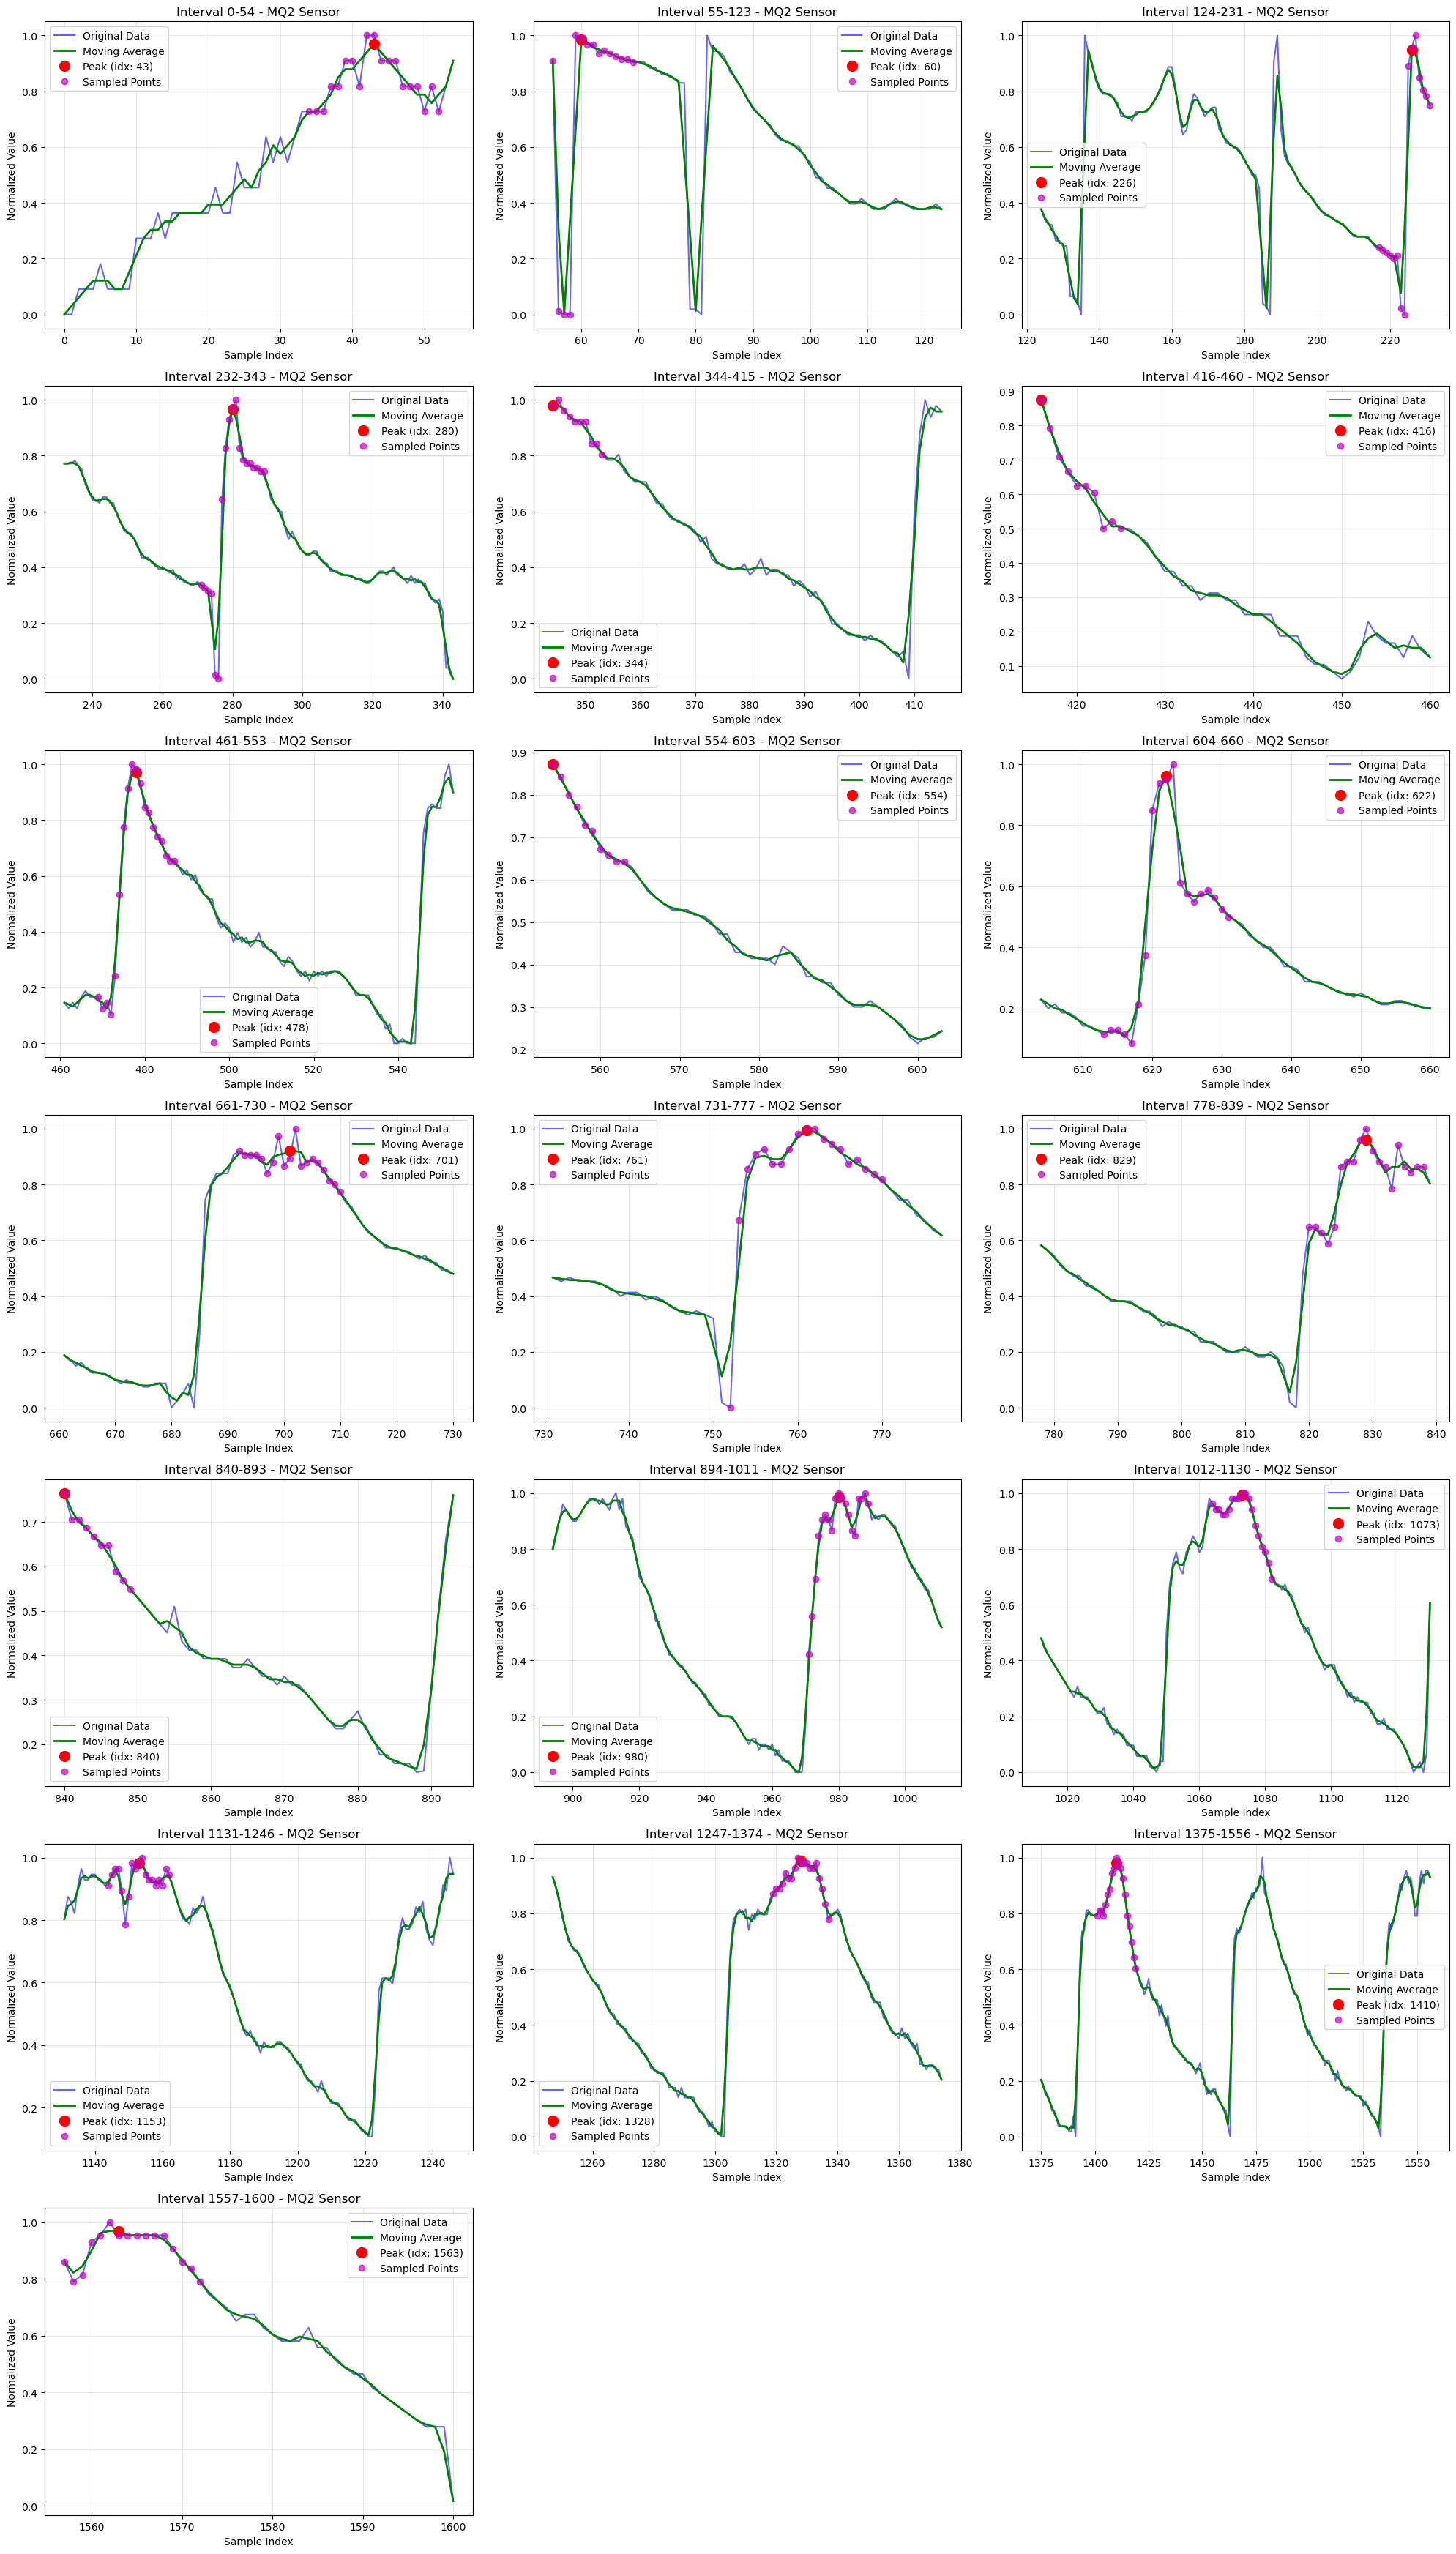

Interval 0-54: Peak at index 43 (value: 0.9697)
  - Interval range: 0-54
  - Sample range: 34-52
Interval 55-123: Peak at index 60 (value: 0.9858)
  - Interval range: 55-123
  - Sample range: 55-69
Interval 124-231: Peak at index 226 (value: 0.9493)
  - Interval range: 124-231
  - Sample range: 217-231
Interval 232-343: Peak at index 280 (value: 0.9667)
  - Interval range: 232-343
  - Sample range: 271-289
Interval 344-415: Peak at index 344 (value: 0.9804)
  - Interval range: 344-415
  - Sample range: 344-353
... (총 19개 주기 중 5개만 표시)
Serial Number                 int64
MQ2                         float64
MQ3                         float64
MQ5                         float64
MQ6                         float64
MQ7                         float64
MQ8                         float64
MQ135                       float64
Gas                          object
Interval                     object
Corresponding Image Name     object
relative_position             int64
is_peak                     

In [158]:
Gas_Leakage_MM = pd.read_csv('/data2/project/2025summer/jjh0709/git/GasLeakage-MultiModal-MTF/Gas_Leakage_MM.csv')

intervals = [
    '0-54', '55-123', '124-231', '232-343', '344-415', '416-460',
    '461-553', '554-603', '604-660', '661-730', '731-777', '778-839',
    '840-893', '894-1011', '1012-1130', '1131-1246', '1247-1374', 
    '1375-1556', '1557-1600'
]

sensor_columns = ['MQ2', 'MQ3', 'MQ5', 'MQ6', 'MQ7', 'MQ8', 'MQ135']

def parse_interval(interval_str):
    start, end = map(int, interval_str.split('-'))
    return start, end

def calculate_moving_average(data, window_size=3):
    return data.rolling(window=window_size, center=True).mean().fillna(data)

def find_peak_in_interval(data, start_idx, end_idx, sensor_col='MQ2'):
    interval_data = data.iloc[start_idx:end_idx+1].copy()
    
    if len(interval_data) < 5:
        return None, None, None
    
    ma_values = calculate_moving_average(interval_data[sensor_col])
    
    peak_idx_relative = ma_values.idxmax()
    peak_idx_absolute = peak_idx_relative
    peak_value = ma_values.loc[peak_idx_relative]
    
    return peak_idx_absolute, peak_value, ma_values

def extract_samples_around_peak(data, peak_idx, before=9, after=9, interval_start=None, interval_end=None):
    start_idx = max(0, peak_idx - before) 
    end_idx = min(len(data) - 1, peak_idx + after) 
    
    if interval_start is not None:
        start_idx = max(interval_start, start_idx)
    if interval_end is not None:
        end_idx = min(interval_end, end_idx)
    
    samples = data.iloc[start_idx:end_idx+1].copy()
    
    samples['relative_position'] = range(start_idx - peak_idx, end_idx - peak_idx + 1)
    samples['is_peak'] = samples.index == peak_idx
    
    actual_before = peak_idx - start_idx
    actual_after = end_idx - peak_idx
    
    
    return samples, start_idx, end_idx

def process_all_intervals(data, intervals, main_sensor='MQ2'):
    all_sampled_data = []
    peak_info = []
    
    n_intervals = len(intervals)
    n_cols = 3
    n_rows = (n_intervals + n_cols - 1) // n_cols
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 5*n_rows))
    axes = axes.flatten() if n_intervals > 1 else [axes]
    
    for i, interval_str in enumerate(intervals):
        start_idx, end_idx = parse_interval(interval_str)
        
        interval_data = data.iloc[start_idx:end_idx+1].copy()
        
        if len(interval_data) == 0:
            continue
            
        peak_idx, peak_value, ma_values = find_peak_in_interval(
            data, start_idx, end_idx, main_sensor
        )
        
        if peak_idx is None:
            continue
            
        samples, sample_start_idx, sample_end_idx = extract_samples_around_peak(
            data, peak_idx, before=9, after=9, interval_start=start_idx, interval_end=end_idx
        )
        
        samples['interval'] = interval_str
        samples['peak_idx'] = peak_idx
        all_sampled_data.append(samples)
        
        peak_info.append({
            'interval': interval_str,
            'peak_idx': peak_idx,
            'peak_value': peak_value,
            'interval_start': start_idx,
            'interval_end': end_idx,
            'sample_start': sample_start_idx,
            'sample_end': sample_end_idx
        })
        
        ax = axes[i]
        
        ax.plot(interval_data.index, interval_data[main_sensor], 'b-', alpha=0.6, label='Original Data')
        
        ax.plot(ma_values.index, ma_values.values, 'g-', linewidth=2, label='Moving Average')
        
        ax.plot(peak_idx, peak_value, 'ro', markersize=10, label=f'Peak (idx: {peak_idx})')
        
        sample_indices = samples.index
        valid_sample_indices = [idx for idx in sample_indices if idx in interval_data.index]
        if valid_sample_indices:
            ax.plot(valid_sample_indices, 
                   interval_data.loc[valid_sample_indices, main_sensor], 'mo', 
                   markersize=6, alpha=0.7, label='Sampled Points')
        
        ax.set_title(f'Interval {interval_str} - {main_sensor} Sensor')
        ax.set_xlabel('Sample Index')
        ax.set_ylabel('Normalized Value')
        ax.legend()
        ax.grid(True, alpha=0.3)
    
    for j in range(i+1, len(axes)):
        fig.delaxes(axes[j])
    
    plt.tight_layout()
    plt.show()
    
    return all_sampled_data, peak_info

sampled_data_list, peak_information = process_all_intervals(Gas_Leakage_MM, intervals)

if sampled_data_list:
    final_sampled_data = pd.concat(sampled_data_list, ignore_index=True)
    


    for info in peak_information[:5]:  
        print(f"Interval {info['interval']}: Peak at index {info['peak_idx']} (value: {info['peak_value']:.4f})")
        print(f"  - Interval range: {info['interval_start']}-{info['interval_end']}")
        print(f"  - Sample range: {info['sample_start']}-{info['sample_end']}")
    
    if len(peak_information) > 5:
        print(f"... (총 {len(peak_information)}개 주기 중 5개만 표시)")
    

    print(final_sampled_data.dtypes)
    
    display_cols = ['Serial Number'] + sensor_columns + ['Gas', 'interval', 'relative_position', 'is_peak']
    print(final_sampled_data[display_cols].head())
    
    interval_counts = final_sampled_data['interval'].value_counts().sort_index()
    print(interval_counts)
    
    
else:
    print('애마하긴 해;;')

In [159]:
from sklearn.model_selection import train_test_split


intervals = [
    '0-54', '55-123', '124-231', '232-343', '344-415', '416-460',
    '461-553', '554-603', '604-660', '661-730', '731-777', '778-839',
    '840-893', '894-1011', '1012-1130', '1131-1246', '1247-1374',
    '1375-1556', '1557-1600'
]


def get_interval_num(interval_str):
    try:
        return intervals.index(interval_str)
    except ValueError:
        return -1  

final_sampled_data['interval_num'] = final_sampled_data['interval'].apply(get_interval_num)


final_sampled_data['stratify_label'] = final_sampled_data['Gas'] + "_" + final_sampled_data['interval_num'].astype(str)

train_df, test_df = train_test_split(
    final_sampled_data,
    test_size=0.2,
    random_state=42,
    stratify=final_sampled_data['stratify_label']
)


def create_metadata(df, set_type):
    df = df.copy()
    

    df['Id'] = df.apply(lambda row: f"{row['Gas']}_{row['interval_num']}_{row['Serial Number']}", axis=1)
    

    df['dataset'] = df['interval_num']
    

    df['gas'] = df['Gas']
    df['interval'] = df['interval']
    df['serial'] = df['Serial Number']
    

    df['train_test'] = set_type
    
    meta_df = df[['Id', 'dataset', 'gas', 'interval', 'serial', 'train_test']]
    
    return meta_df

train_meta = create_metadata(train_df, 'train')
test_meta = create_metadata(test_df, 'test')

metadata_final = pd.concat([train_meta, test_meta], ignore_index=True)

metadata_final.to_csv('Gas_Sensor_Metadata_TrainTest.csv', index=False, encoding='utf-8-sig')

print(metadata_final.head())


              Id  dataset    gas   interval  serial train_test
0    NoGas_3_285        3  NoGas    232-343     285      train
1   NoGas_13_988       13  NoGas   894-1011     988      train
2   NoGas_10_761       10  NoGas    731-777     761      train
3  NoGas_14_1078       14  NoGas  1012-1130    1078      train
4    NoGas_2_217        2  NoGas    124-231     217      train


In [160]:
from sklearn.model_selection import train_test_split

# 구간 리스트 정의 (processed_smoke_df의 Interval 값들 사용)
intervals = processed_smoke_df['Interval'].unique().tolist()
intervals.sort()  # 정렬
print("사용할 구간들:", intervals)

def get_interval_num(interval_str):
    """구간 문자열을 숫자로 변환"""
    try:
        return intervals.index(interval_str)
    except ValueError:
        return -1  

# 구간 번호와 stratify 라벨 추가
processed_smoke_df['interval_num'] = processed_smoke_df['Interval'].apply(get_interval_num)
processed_smoke_df['stratify_label'] = processed_smoke_df['Gas'] + "_" + processed_smoke_df['interval_num'].astype(str)

# Stratified split (가스 타입과 구간을 모두 고려)
train_df, test_df = train_test_split(
    processed_smoke_df,
    test_size=0.2,
    random_state=42,
    stratify=processed_smoke_df['stratify_label']
)

print(f"Train 데이터: {len(train_df)}개")
print(f"Test 데이터: {len(test_df)}개")

def create_metadata(df, set_type):
    """메타데이터 생성"""
    df = df.copy()
    
    # ID 생성: 가스타입_구간번호_시리얼번호
    df['Id'] = df.apply(lambda row: f"{row['Gas']}_{row['interval_num']}_{row['Serial Number']}", axis=1)
    
    # 메타데이터 컬럼들
    df['dataset'] = df['interval_num']
    df['gas'] = df['Gas']
    df['interval'] = df['Interval']  # 원본 구간 문자열
    df['serial'] = df['Serial Number']
    df['train_test'] = set_type
    
    # 필요한 컬럼만 선택
    meta_df = df[['Id', 'dataset', 'gas', 'interval', 'serial', 'train_test']]
    
    return meta_df

# 메타데이터 생성
train_meta = create_metadata(train_df, 'train')
test_meta = create_metadata(test_df, 'test')

# 통합 메타데이터
metadata_final = pd.concat([train_meta, test_meta], ignore_index=True)

# CSV 저장
metadata_final.to_csv('Gas_Sensor_Metadata_TrainTest.csv', index=False, encoding='utf-8-sig')

print("메타데이터 생성 완료!")
print(f"메타데이터 shape: {metadata_final.shape}")
print("\n메타데이터 샘플:")
print(metadata_final.head())

# 분포 확인
print(f"\n=== Train/Test 분포 ===")
print(metadata_final['train_test'].value_counts())
print(f"\n=== 구간별 분포 ===")
print(metadata_final.groupby(['interval', 'train_test']).size().unstack(fill_value=0))

사용할 구간들: ['0-43', '1018-1095', '102-198', '1096-1175', '1176-1251', '1252-1324', '1325-1401', '1402-1459', '1460-1534', '1535-1599', '199-250', '251-330', '331-439', '44-101', '440-511', '512-609', '610-703', '704-823', '824-951', '952-1017']
Train 데이터: 1280개
Test 데이터: 320개
메타데이터 생성 완료!
메타데이터 shape: (1600, 6)

메타데이터 샘플:
             Id  dataset    gas   interval  serial train_test
0  Smoke_6_1363        6  Smoke  1325-1401    1363      train
1    Smoke_0_30        0  Smoke       0-43      30      train
2  Smoke_11_316       11  Smoke    251-330     316      train
3  Smoke_17_807       17  Smoke    704-823     807      train
4  Smoke_12_386       12  Smoke    331-439     386      train

=== Train/Test 분포 ===
train_test
train    1280
test      320
Name: count, dtype: int64

=== 구간별 분포 ===
train_test  test  train
interval               
0-43           9     35
1018-1095     16     62
102-198       19     78
1096-1175     16     64
1176-1251     15     61
1252-1324     15     58
1325-1401 

/tmp/ipykernel_802562/4212973535.py:29: UserWarning: Glyph 51221 (\N{HANGUL SYLLABLE JEONG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_802562/4212973535.py:29: UserWarning: Glyph 44508 (\N{HANGUL SYLLABLE GYU}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_802562/4212973535.py:29: UserWarning: Glyph 54868 (\N{HANGUL SYLLABLE HWA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_802562/4212973535.py:29: UserWarning: Glyph 46108 (\N{HANGUL SYLLABLE DOEN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_802562/4212973535.py:29: UserWarning: Glyph 44050 (\N{HANGUL SYLLABLE GABS}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_802562/4212973535.py:29: UserWarning: Glyph 49468 (\N{HANGUL SYLLABLE SEN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_802562/4212973535.py:29: UserWarning: Glyph 49436 (\N{HANGUL SYLLABLE SEO}) missing from font(s) DejaVu S

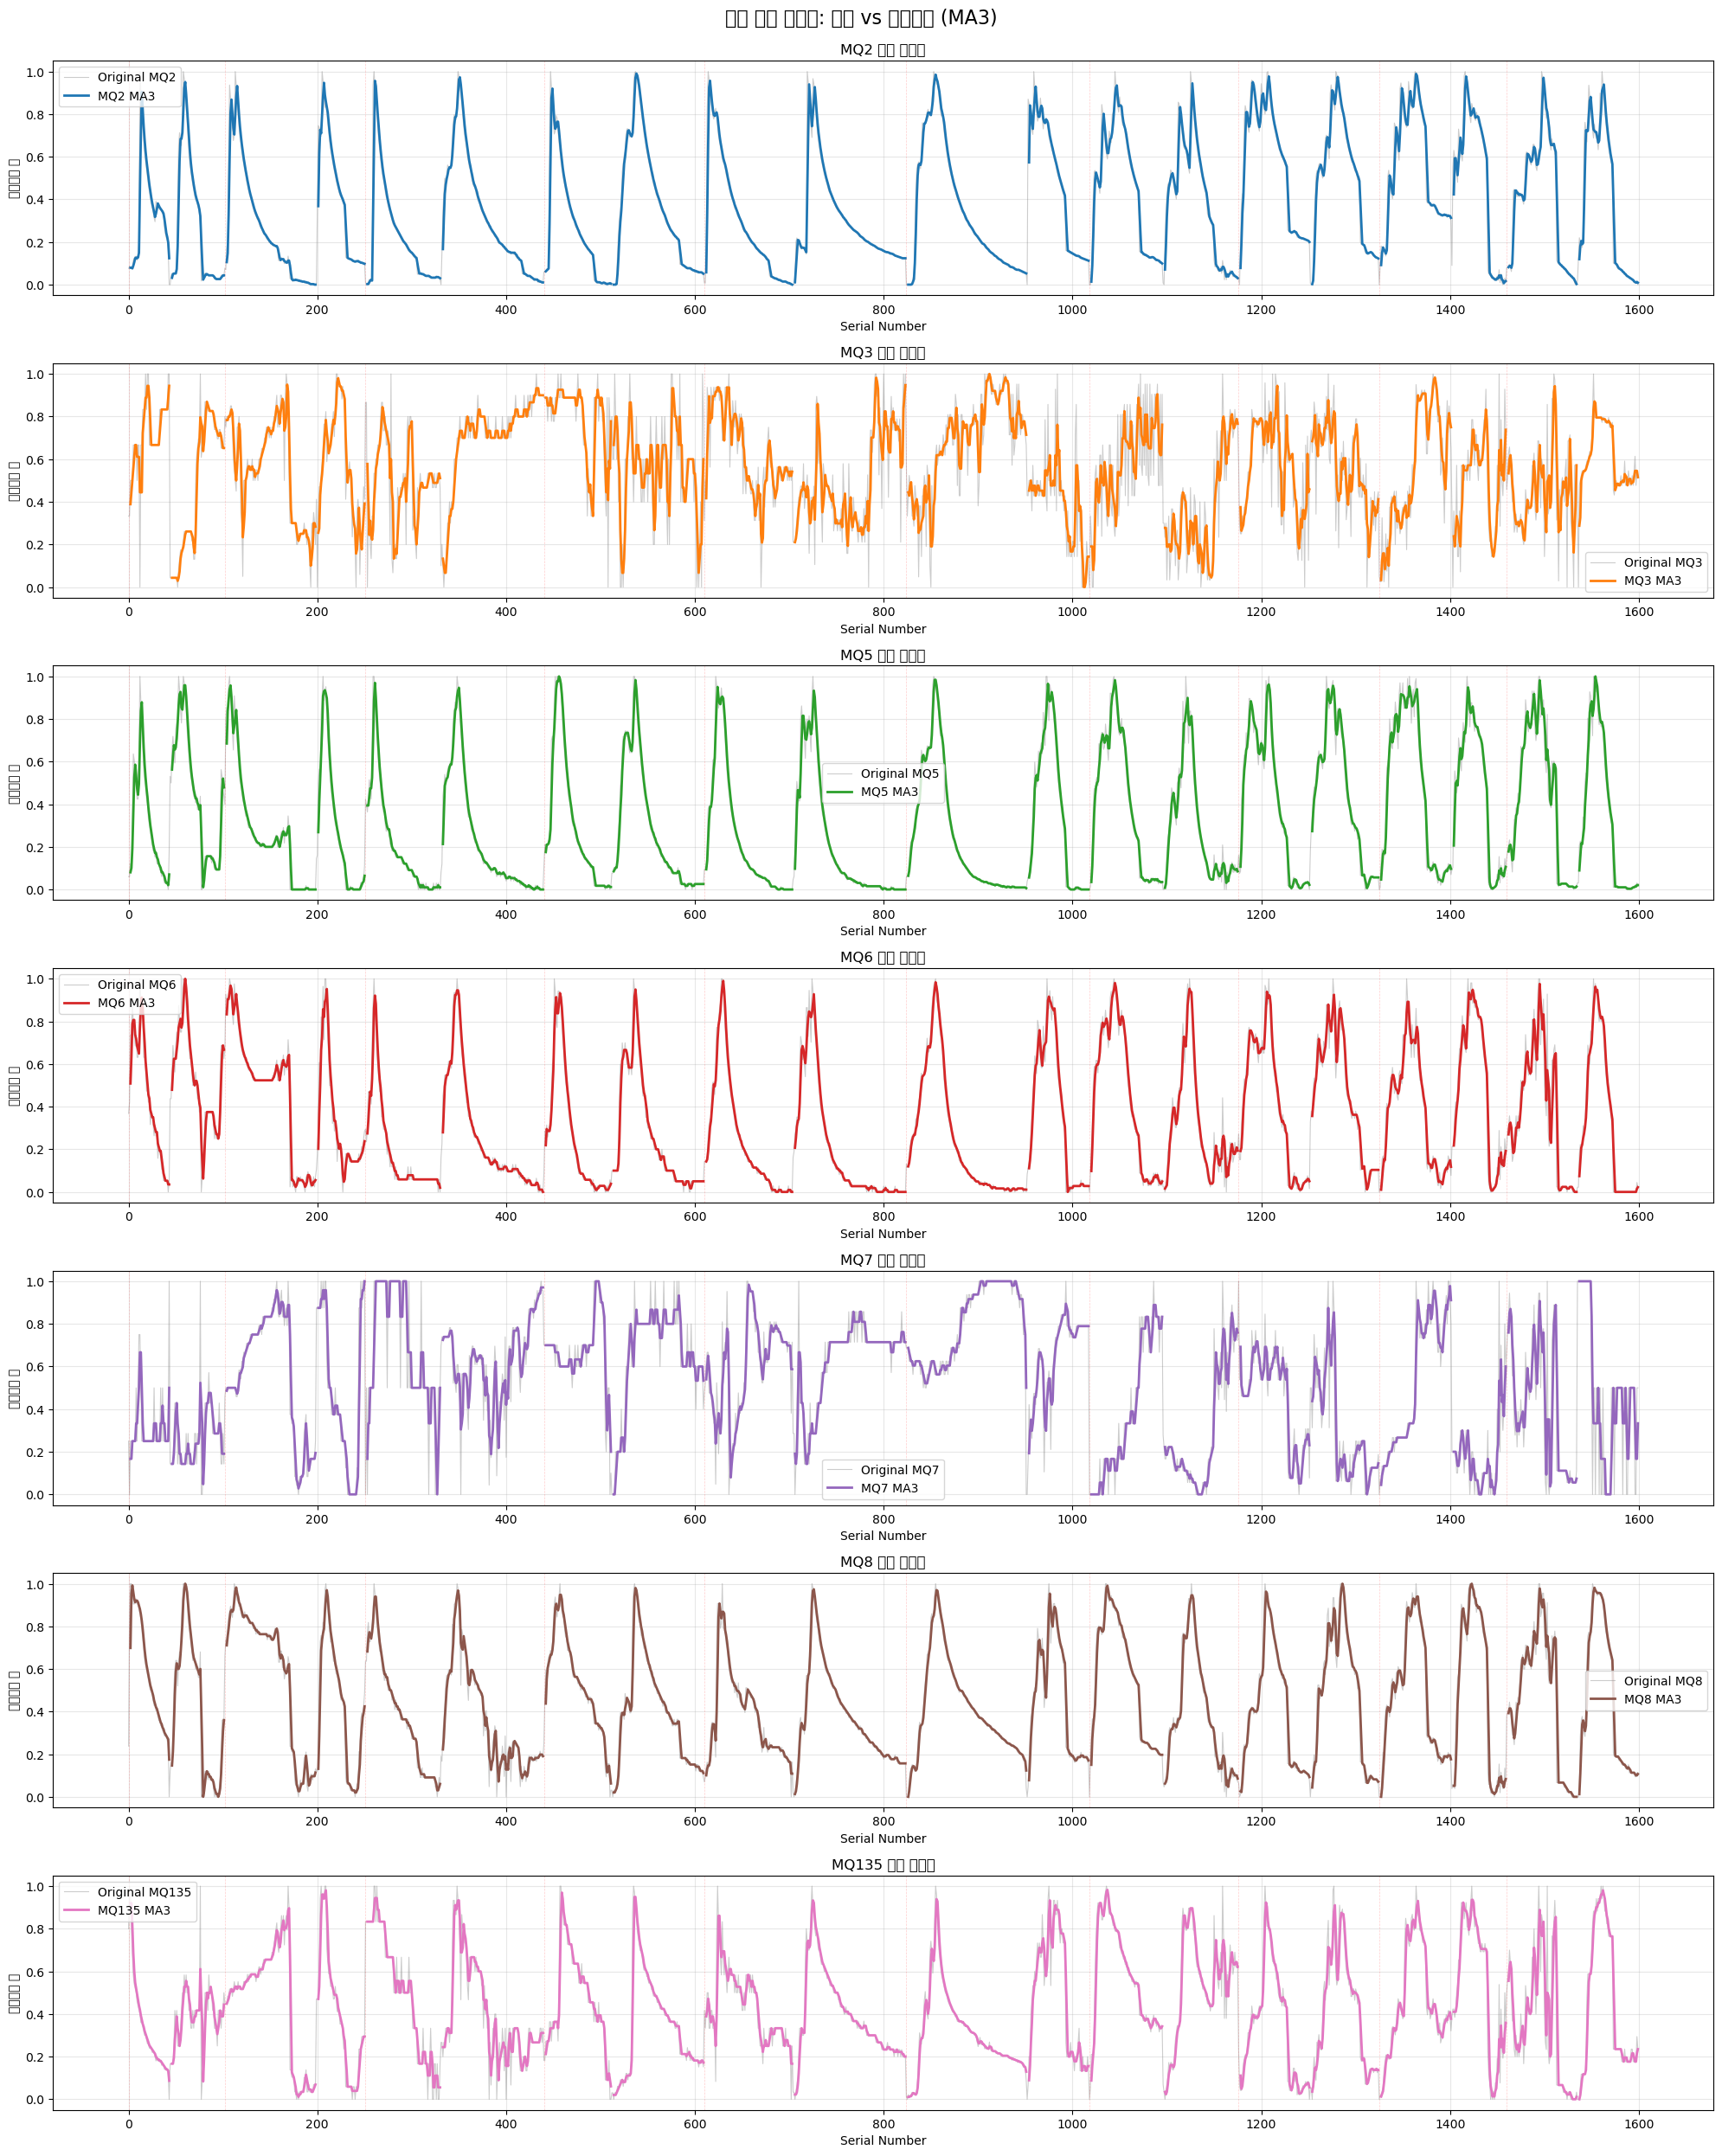

=== 센서별 이동평균 통계 ===
MQ2:
  원본 표준편차: 0.2958
  MA3 표준편차: 0.2898
  노이즈 감소율: 2.1%

MQ3:
  원본 표준편차: 0.2522
  MA3 표준편차: 0.2266
  노이즈 감소율: 10.2%

MQ5:
  원본 표준편차: 0.3129
  MA3 표준편차: 0.3104
  노이즈 감소율: 0.8%

MQ6:
  원본 표준편차: 0.3026
  MA3 표준편차: 0.2993
  노이즈 감소율: 1.1%

MQ7:
  원본 표준편차: 0.3010
  MA3 표준편차: 0.2859
  노이즈 감소율: 5.0%

MQ8:
  원본 표준편차: 0.2860
  MA3 표준편차: 0.2801
  노이즈 감소율: 2.1%

MQ135:
  원본 표준편차: 0.2602
  MA3 표준편차: 0.2509
  노이즈 감소율: 3.6%



/tmp/ipykernel_802562/4212973535.py:69: UserWarning: Glyph 49468 (\N{HANGUL SYLLABLE SEN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_802562/4212973535.py:69: UserWarning: Glyph 49436 (\N{HANGUL SYLLABLE SEO}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_802562/4212973535.py:69: UserWarning: Glyph 45936 (\N{HANGUL SYLLABLE DE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_802562/4212973535.py:69: UserWarning: Glyph 51060 (\N{HANGUL SYLLABLE I}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_802562/4212973535.py:69: UserWarning: Glyph 53552 (\N{HANGUL SYLLABLE TEO}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_802562/4212973535.py:69: UserWarning: Glyph 50836 (\N{HANGUL SYLLABLE YO}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_802562/4212973535.py:69: UserWarning: Glyph 50557 (\N{HANGUL SYLLABLE YAG}) missing from font(s) DejaVu Sans.
  p

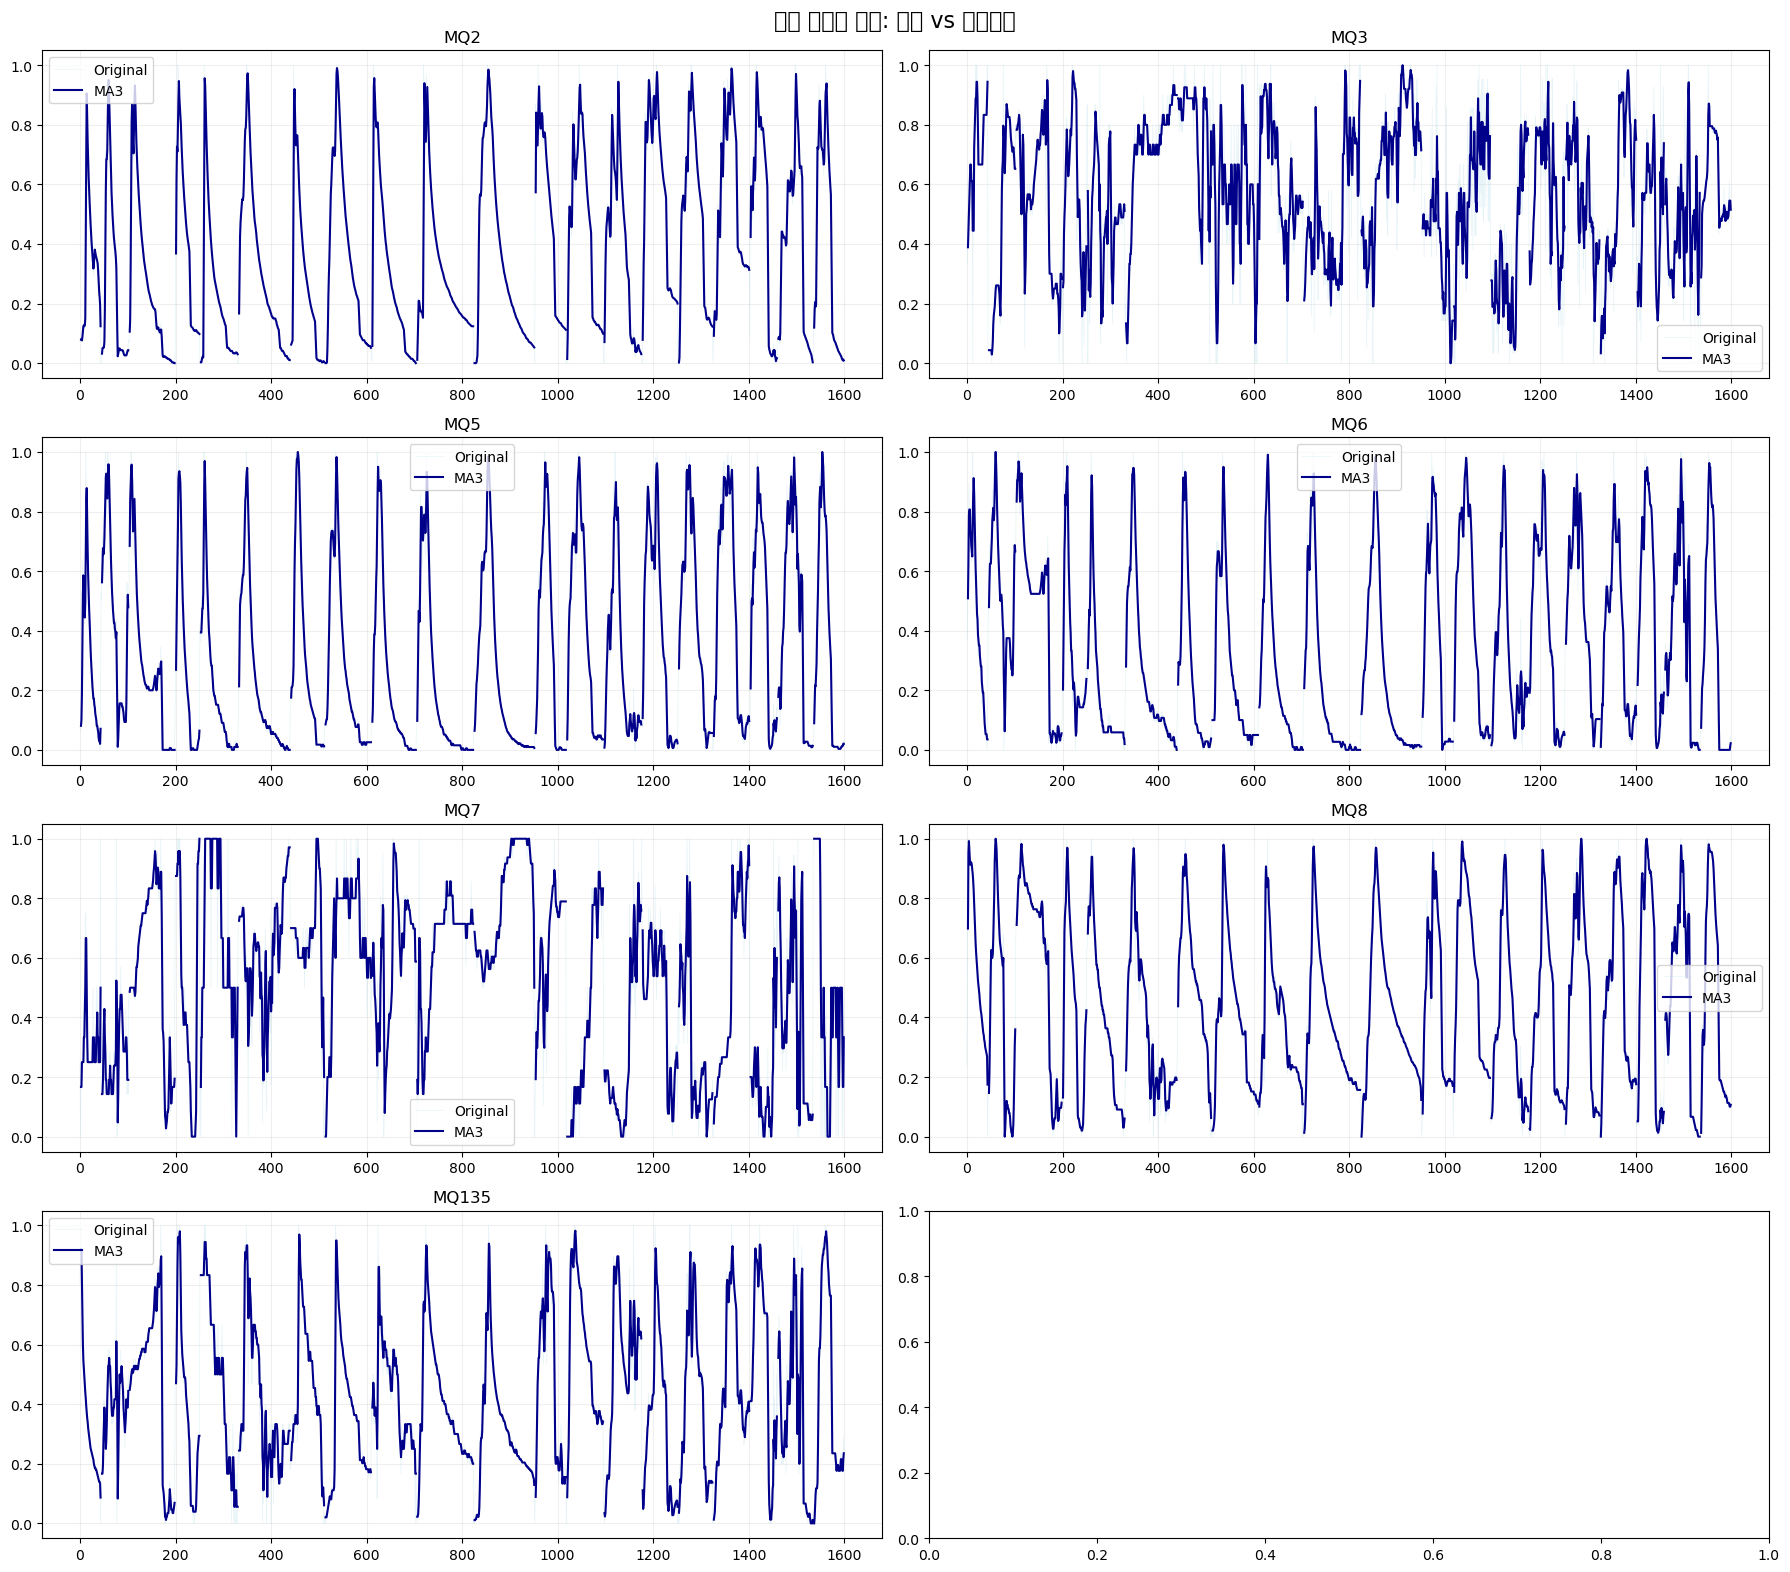

In [59]:
# 전체 센서 이동평균 시각화
sensor_cols = ['MQ2', 'MQ3', 'MQ5', 'MQ6', 'MQ7', 'MQ8', 'MQ135']
window = 3  # 사용한 윈도우 크기에 맞게 조정

# 전체 센서 그래프 (7개 센서 모두)
fig, axes = plt.subplots(7, 1, figsize=(20, 25))
fig.suptitle('전체 센서 데이터: 원본 vs 이동평균 (MA3)', fontsize=16, y=0.995)

for i, sensor in enumerate(sensor_cols):
    # 원본 데이터
    axes[i].plot(segment_ma_df['Serial Number'], segment_ma_df[sensor], 
                alpha=0.4, color='gray', linewidth=0.8, label=f'Original {sensor}')
    
    # 이동평균 데이터
    if f'{sensor}_MA{window}' in segment_ma_df.columns:
        axes[i].plot(segment_ma_df['Serial Number'], segment_ma_df[f'{sensor}_MA{window}'], 
                    color=plt.cm.tab10(i), linewidth=2, label=f'{sensor} MA{window}')
    
    axes[i].set_title(f'{sensor} 센서 데이터', fontsize=12)
    axes[i].set_xlabel('Serial Number')
    axes[i].set_ylabel('정규화된 값')
    axes[i].legend()
    axes[i].grid(True, alpha=0.3)
    
    # 구간 구분선 추가 (선택사항)
    for start, end in ranges[::2]:  # 몇 개만 표시
        axes[i].axvline(x=start, color='red', alpha=0.2, linestyle='--', linewidth=0.5)

plt.tight_layout()
plt.show()

# 센서별 통계 정보
print("=== 센서별 이동평균 통계 ===")
for sensor in sensor_cols:
    if f'{sensor}_MA{window}' in segment_ma_df.columns:
        original_std = segment_ma_df[sensor].std()
        ma_std = segment_ma_df[f'{sensor}_MA{window}'].std()
        noise_reduction = (1 - ma_std/original_std) * 100
        
        print(f"{sensor}:")
        print(f"  원본 표준편차: {original_std:.4f}")
        print(f"  MA{window} 표준편차: {ma_std:.4f}")
        print(f"  노이즈 감소율: {noise_reduction:.1f}%")
        print()

# 간단한 4x2 레이아웃 버전 (보기 쉬운 버전)
fig, axes = plt.subplots(4, 2, figsize=(18, 16))
fig.suptitle('센서 데이터 요약: 원본 vs 이동평균', fontsize=16)
axes = axes.flatten()

for i, sensor in enumerate(sensor_cols):
    if i < 8:  # 7개 센서 + 1개 여유공간
        if i < len(sensor_cols):
            # 원본 데이터
            axes[i].plot(segment_ma_df['Serial Number'], segment_ma_df[sensor], 
                        alpha=0.3, color='lightblue', linewidth=0.5, label='Original')
            
            # 이동평균 데이터
            if f'{sensor}_MA{window}' in segment_ma_df.columns:
                axes[i].plot(segment_ma_df['Serial Number'], segment_ma_df[f'{sensor}_MA{window}'], 
                            color='darkblue', linewidth=1.5, label=f'MA{window}')
            
            axes[i].set_title(f'{sensor}', fontsize=12)
            axes[i].legend()
            axes[i].grid(True, alpha=0.2)
        else:
            axes[i].set_visible(False)  # 마지막 빈 공간 숨기기

plt.tight_layout()
plt.show()

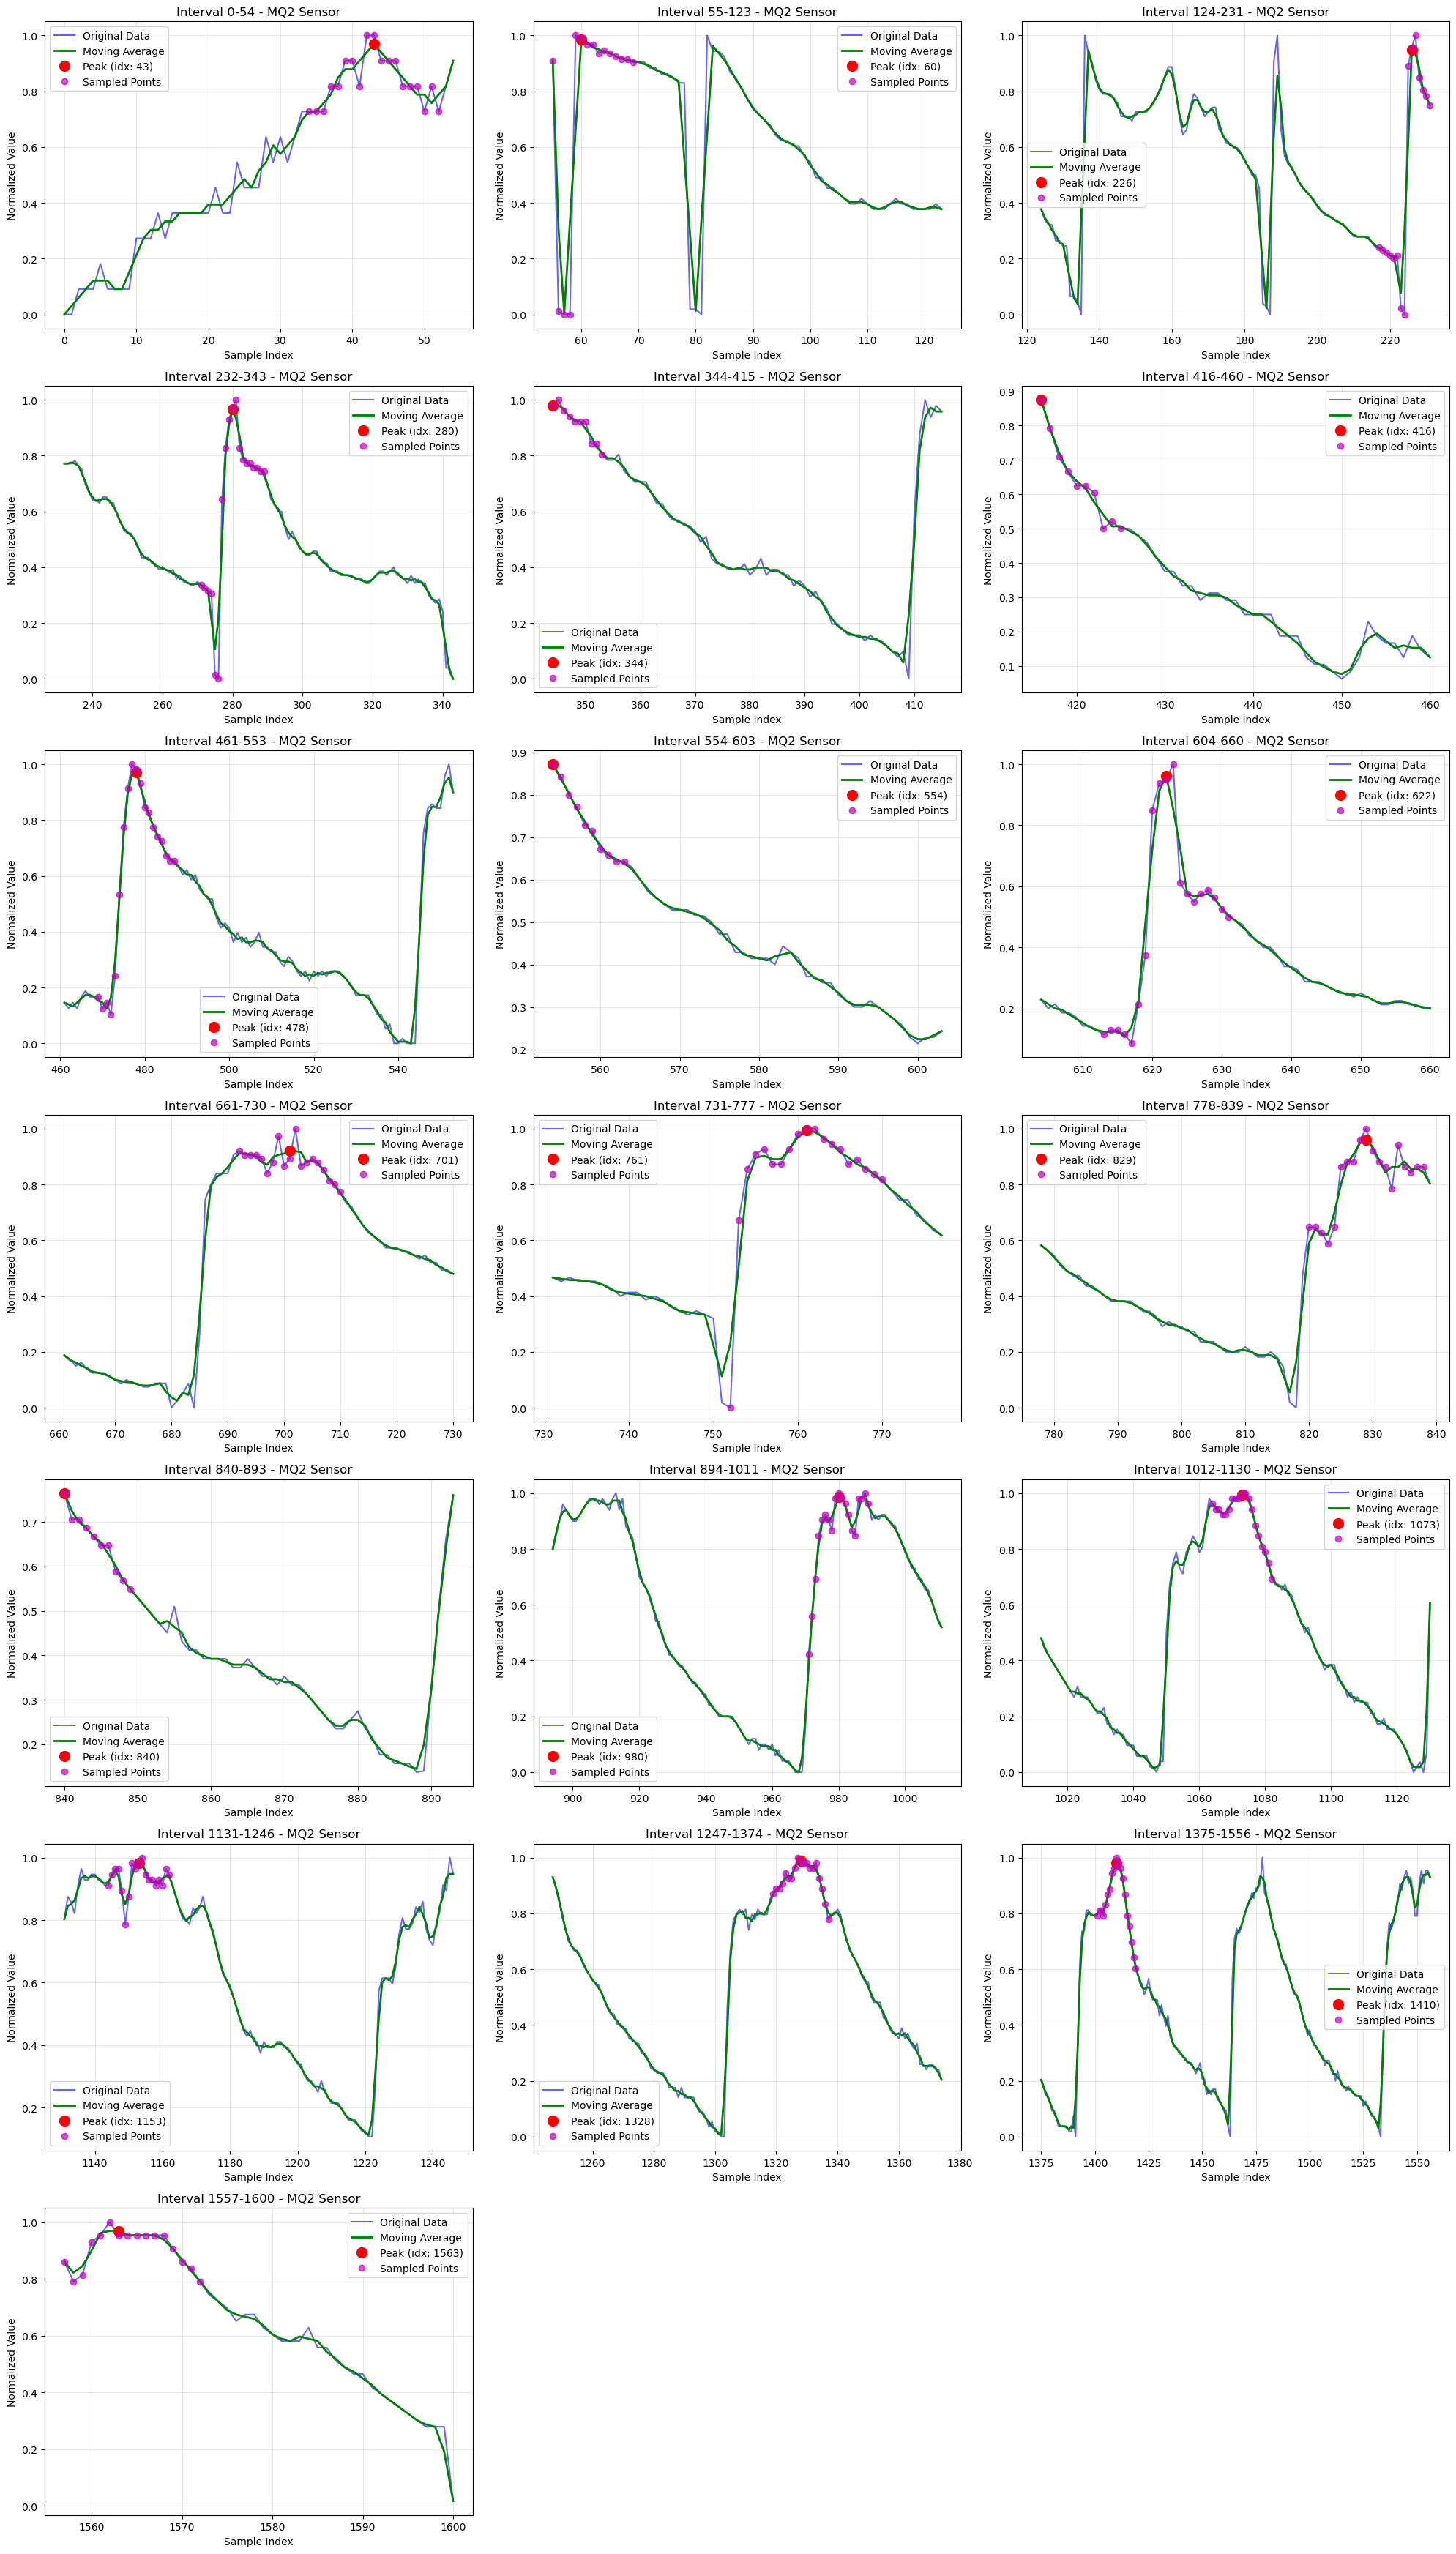

Interval 0-54: Peak at index 43 (value: 0.9697)
  - Interval range: 0-54
  - Sample range: 34-52
Interval 55-123: Peak at index 60 (value: 0.9858)
  - Interval range: 55-123
  - Sample range: 55-69
Interval 124-231: Peak at index 226 (value: 0.9493)
  - Interval range: 124-231
  - Sample range: 217-231
Interval 232-343: Peak at index 280 (value: 0.9667)
  - Interval range: 232-343
  - Sample range: 271-289
Interval 344-415: Peak at index 344 (value: 0.9804)
  - Interval range: 344-415
  - Sample range: 344-353
... (총 19개 주기 중 5개만 표시)
Serial Number                 int64
MQ2                         float64
MQ3                         float64
MQ5                         float64
MQ6                         float64
MQ7                         float64
MQ8                         float64
MQ135                       float64
Gas                          object
Interval                     object
Corresponding Image Name     object
relative_position             int64
is_peak                     

In [43]:
Gas_Leakage_MM = pd.read_csv('/data2/project/2025summer/jjh0709/git/GasLeakage-MultiModal-MTF/Gas_Leakage_MM.csv')

intervals = [
    '0-54', '55-123', '124-231', '232-343', '344-415', '416-460',
    '461-553', '554-603', '604-660', '661-730', '731-777', '778-839',
    '840-893', '894-1011', '1012-1130', '1131-1246', '1247-1374', 
    '1375-1556', '1557-1600'
]

sensor_columns = ['MQ2', 'MQ3', 'MQ5', 'MQ6', 'MQ7', 'MQ8', 'MQ135']

def parse_interval(interval_str):
    start, end = map(int, interval_str.split('-'))
    return start, end

def calculate_moving_average(data, window_size=3):
    return data.rolling(window=window_size, center=True).mean().fillna(data)

def find_peak_in_interval(data, start_idx, end_idx, sensor_col='MQ2'):
    interval_data = data.iloc[start_idx:end_idx+1].copy()
    
    if len(interval_data) < 5:
        return None, None, None
    
    ma_values = calculate_moving_average(interval_data[sensor_col])
    
    peak_idx_relative = ma_values.idxmax()
    peak_idx_absolute = peak_idx_relative
    peak_value = ma_values.loc[peak_idx_relative]
    
    return peak_idx_absolute, peak_value, ma_values

def extract_samples_around_peak(data, peak_idx, before=9, after=9, interval_start=None, interval_end=None):
    start_idx = max(0, peak_idx - before) 
    end_idx = min(len(data) - 1, peak_idx + after) 
    
    if interval_start is not None:
        start_idx = max(interval_start, start_idx)
    if interval_end is not None:
        end_idx = min(interval_end, end_idx)
    
    samples = data.iloc[start_idx:end_idx+1].copy()
    
    samples['relative_position'] = range(start_idx - peak_idx, end_idx - peak_idx + 1)
    samples['is_peak'] = samples.index == peak_idx
    
    actual_before = peak_idx - start_idx
    actual_after = end_idx - peak_idx
    
    
    return samples, start_idx, end_idx

def process_all_intervals(data, intervals, main_sensor='MQ2'):
    all_sampled_data = []
    peak_info = []
    
    n_intervals = len(intervals)
    n_cols = 3
    n_rows = (n_intervals + n_cols - 1) // n_cols
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 5*n_rows))
    axes = axes.flatten() if n_intervals > 1 else [axes]
    
    for i, interval_str in enumerate(intervals):
        start_idx, end_idx = parse_interval(interval_str)
        
        interval_data = data.iloc[start_idx:end_idx+1].copy()
        
        if len(interval_data) == 0:
            continue
            
        peak_idx, peak_value, ma_values = find_peak_in_interval(
            data, start_idx, end_idx, main_sensor
        )
        
        if peak_idx is None:
            continue
            
        samples, sample_start_idx, sample_end_idx = extract_samples_around_peak(
            data, peak_idx, before=9, after=9, interval_start=start_idx, interval_end=end_idx
        )
        
        samples['interval'] = interval_str
        samples['peak_idx'] = peak_idx
        all_sampled_data.append(samples)
        
        peak_info.append({
            'interval': interval_str,
            'peak_idx': peak_idx,
            'peak_value': peak_value,
            'interval_start': start_idx,
            'interval_end': end_idx,
            'sample_start': sample_start_idx,
            'sample_end': sample_end_idx
        })
        
        ax = axes[i]
        
        ax.plot(interval_data.index, interval_data[main_sensor], 'b-', alpha=0.6, label='Original Data')
        
        ax.plot(ma_values.index, ma_values.values, 'g-', linewidth=2, label='Moving Average')
        
        ax.plot(peak_idx, peak_value, 'ro', markersize=10, label=f'Peak (idx: {peak_idx})')
        
        sample_indices = samples.index
        valid_sample_indices = [idx for idx in sample_indices if idx in interval_data.index]
        if valid_sample_indices:
            ax.plot(valid_sample_indices, 
                   interval_data.loc[valid_sample_indices, main_sensor], 'mo', 
                   markersize=6, alpha=0.7, label='Sampled Points')
        
        ax.set_title(f'Interval {interval_str} - {main_sensor} Sensor')
        ax.set_xlabel('Sample Index')
        ax.set_ylabel('Normalized Value')
        ax.legend()
        ax.grid(True, alpha=0.3)
    
    for j in range(i+1, len(axes)):
        fig.delaxes(axes[j])
    
    plt.tight_layout()
    plt.show()
    
    return all_sampled_data, peak_info

sampled_data_list, peak_information = process_all_intervals(Gas_Leakage_MM, intervals)

if sampled_data_list:
    final_sampled_data = pd.concat(sampled_data_list, ignore_index=True)
    


    for info in peak_information[:5]:  
        print(f"Interval {info['interval']}: Peak at index {info['peak_idx']} (value: {info['peak_value']:.4f})")
        print(f"  - Interval range: {info['interval_start']}-{info['interval_end']}")
        print(f"  - Sample range: {info['sample_start']}-{info['sample_end']}")
    
    if len(peak_information) > 5:
        print(f"... (총 {len(peak_information)}개 주기 중 5개만 표시)")
    

    print(final_sampled_data.dtypes)
    
    display_cols = ['Serial Number'] + sensor_columns + ['Gas', 'interval', 'relative_position', 'is_peak']
    print(final_sampled_data[display_cols].head())
    
    interval_counts = final_sampled_data['interval'].value_counts().sort_index()
    print(interval_counts)
    
    
else:
    print('애마하긴 해;;')